In [1]:
import os

# choose the GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# disable preallocation of memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# pcx
import pcx as px
import pcx.predictive_coding as pxc
import pcx.nn as pxnn
import pcx.functional as pxf
import pcx.utils as pxu

# 3rd party
import jax
from jax import jit
import jax.numpy as jnp
import jax.numpy.linalg as jax_numpy_linalg # for expm()
import jax.scipy.linalg as jax_scipy_linalg # for slogdet()

import jax.random as random
import optax
import numpy as np
import pandas as pd
from pandas.api.types import is_float_dtype
from ucimlrepo import fetch_ucirepo 

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
import timeit
from sklearn.metrics import f1_score

# own
import causal_helpers
from causal_helpers import simulate_dag, simulate_parameter, simulate_linear_sem, simulate_linear_sem_cyclic
from causal_helpers import load_adjacency_matrix, set_random_seed, plot_adjacency_matrices
from causal_helpers import load_graph, load_adjacency_matrix
from causal_metrics import compute_F1_directed, compute_F1_skeleton, compute_AUPRC, compute_AUROC, compute_cycle_F1
from causal_metrics import compute_SHD, compute_SID, compute_ancestor_AID, compute_TEE
from connectome_cyclic_data_generator import sample_cyclic_data

# Set random seed
seed = 2 # main seed for reproducibility
set_random_seed(seed)

# causal libraries
import cdt, castle
from castle.algorithms import GOLEM
from castle.algorithms import Notears
from castle.algorithms import PC
from castle.algorithms.ges.ges import GES
from castle.algorithms import DirectLiNGAM
from castle.algorithms import ICALiNGAM

import lingam

# causal metrics
from cdt.metrics import precision_recall, SHD, SID
from castle.metrics import MetricsDAG
from castle.common import GraphDAG
from causallearn.graph.SHD import SHD as SHD_causallearn

######################### mcmiknn #########################

from causal_model import mCMIkNN
from itertools import combinations, product, chain
from multiprocessing import Pool, RawArray
import logging
from datetime import datetime

/share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Detecting CUDA device(s) : [1]
2025-02-10 08:07:41,637 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2025-02-10 08:07:41,646 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


In [2]:
import pandas as pd
#   # fetch dataset 
# abalone = fetch_ucirepo(id=1) 
  
# # data (as pandas dataframes) 
# X = abalone.data.features
# y = abalone.data.targets
  
# # metadata 
# #print(abalone.metadata) 

# # now merge X and y to create a single dataframe and give the columns the correct names using abalone.variables.name.values
# df = pd.concat([X, y], axis=1)
# df.columns = abalone.variables.name.values.tolist()
# print(df.head())
# print()
# # show # of unique values in each column
# print(df.nunique())
# # finally convert the Rings variable to a binary variable by setting the threshold to mean(rings)
# df['Rings'] = df['Rings'] > df['Rings'].mean()
# # then convert to integer
# df['Rings'] = df['Rings'].astype(int)
# # also replace the values in Sex with integers
# df['Sex'] = df['Sex'].map({'M': 0, 'F': 1, 'I': 2})

# # now show the first 5 rows of the dataframe
# print(df.head())

# # Create a boolean list for continuous variables (any float dtype)
# is_cont_node = df.dtypes.map(is_float_dtype).tolist()

# # Print the result
# print(is_cont_node)

# # plot the distribution of all variables in the dataframe
# df.hist(figsize=(15, 10))
# plt.show()

# path to mixed_confounding data
#path = '../data/custom_mixed_confounding/'
path = '../data/custom_mixed_confounding_softplus/'

# file name adjacency matrix in csv format
mixed_confounding_adjacency_matrix = 'adj_matrix.csv'
# file name observational data in csv format
mixed_confounding_obs_data = 'train.csv'

# load adjacency matrix and data as pandas dataframe, both files have no header
adj_matrix = pd.read_csv(path + mixed_confounding_adjacency_matrix, header=None)
X_df = pd.read_csv(path + mixed_confounding_obs_data, header=None)
weighted_adj_matrix = pd.read_csv(path + 'W_adj_matrix.csv', header=None)

B_true = adj_matrix.values
X = X_df.values
W_true = weighted_adj_matrix.values

In [3]:
X_df.head()
# show unique values in each column
print(X_df.nunique())
# Determine if each variable is continuous or discrete based on the number of unique values
is_cont_node = np.array([True if X_df[col].nunique() > 2 else False for col in X_df.columns])
is_cont_node = is_cont_node.tolist()
print(is_cont_node)

0        2
1     4000
2        2
3     4000
4        2
5        2
6     4000
7        2
8     4000
9     4000
10    4000
11    4000
dtype: int64
[False, True, False, True, False, False, True, False, True, True, True, True]


In [4]:
# # ## Load the actual connectome data

# # %%
# # load the weighted adjacency matrices for ER and connectome

# # Specify the folder where the adjacency matrices were saved
# folder = '../data/'

# # Specify the folder where the acyclic positive integer weighted connectome data was saved
# folder_cyclic = '/home/amine.mcharrak/connectome/data/'
# # Specify the folder where the acyclic positive integer weighted connectome data was saved
# folder_acyclic = '/home/amine.mcharrak/connectome/data/'

# # Example usage to load the saved adjacency matrices
# # G_A_init_t_ordered_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_adj_matrix.npy'))
# # G_A_init_t_ordered_dag_adj_matrix = load_adjacency_matrix(os.path.join(folder, 'G_A_init_t_ordered_dag_adj_matrix.npy'))
# # ER = load_adjacency_matrix(os.path.join(folder, 'ER_adj_matrix.npy'))
# # ER_dag = load_adjacency_matrix(os.path.join(folder, 'ER_dag_adj_matrix.npy'))

# # Change name of the connectome adjacency matrix to C and C_dag
# # C = G_A_init_t_ordered_adj_matrix
# # C_dag = G_A_init_t_ordered_dag_adj_matrix

# # Now ensure that both DAG adjacency matrices are binary, if they aren't already
# # ER_dag_bin = (ER_dag != 0).astype(int)
# # C_dag_bin = (C_dag != 0).astype(int)

# # ER_true = ER_dag_bin
# # C_true = C_dag_bin

# # %% [markdown]
# # ## Create data to debug and implement the pcax version of NOTEARS

# # %%
# # actual data
# B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2
# # B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4
# # debugging data
# # B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2


# # B_true = C_dag_bin # if you want to use the connectome-based DAG # best
# #B_true = ER_dag_bin # if you want to use the ER-based DAG

# #B_true = simulate_dag(d=5, s0=10, graph_type='ER') # ER2
# #B_true = simulate_dag(d=10, s0=20, graph_type='ER') # ER2
# #B_true = simulate_dag(d=50, s0=100, graph_type='ER') # ER2
# #B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
# #B_true = simulate_dag(d=279, s0=558, graph_type='ER') # ER2

# # create SF2 graph and SF4 graph with d=10 nodes
# #B_true = simulate_dag(d=10, s0=20, graph_type='SF') # SF2
# #B_true = simulate_dag(d=10, s0=40, graph_type='SF') # SF4
# #B_true = simulate_dag(d=100, s0=400, graph_type='SF') # SF4

# # create ER2 and ER4 graphs with d=100 nodes
# #B_true = simulate_dag(d=100, s0=200, graph_type='ER') # ER2
# #B_true = simulate_dag(d=100, s0=400, graph_type='ER') # ER4

# # create equivalent ER4 and ER6 graphs
# #B_true = simulate_dag(d=279, s0=1116, graph_type='ER') # ER4
# #B_true = simulate_dag(d=279, s0=1674, graph_type='ER') # ER6

# # create equivalent SF4 and SF6 graphs
# #B_true = simulate_dag(d=100, s0=600, graph_type='SF') # SF6
# #B_true = simulate_dag(d=279, s0=1116, graph_type='SF') # SF4
# #B_true = simulate_dag(d=279, s0=1674, graph_type='SF') # SF6

# # create simple data using simulate_dag method from causal_helpers with expected number of edges (s0) and number of nodes (d)
# #B_true = simulate_dag(d=100, s0=199, graph_type='ER') # we use p≈0.040226 for the connectome-based ER_dag graph. This means that the expected number of edges is 0.040226 * d * (d-1) / 2
# # examples: d=50 -> s0=49 (works), d=100 -> s0=199, d=200 -> s0=800

# # create the weighted adjacency matrix based on the binary adjacency matrix
# #W_true = simulate_parameter(B_true, connectome=True)
# #W_true = simulate_parameter(B_true)

# # sample data from the linear SEM
# # actual data
# #X = simulate_linear_sem(W_true, n=10000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=10000, sem_type='uniform')
# # for debugging
# #X = simulate_linear_sem(W_true, n=1000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=2500, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=6250, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=50000, sem_type='gauss')
# #X = simulate_linear_sem(W_true, n=100000, sem_type='gauss') # 1000*(279**2)/(20**2) = 194602

# # load the cyclic integer weighted connectome data adjacency matrix
# #B_true_weighted = load_adjacency_matrix(os.path.join(folder_cyclic, 'A_init_t_ordered_adj_matrix_with_cycles.npy'))
# #X, W_true = sample_cyclic_data(B_true_weighted, n_samples=10000, noise_type='non-gaussian')
# #B_true = (W_true != 0).astype(int)

# # load the acyclic integer weighted connectome data adjacency matrix
# # B_true_weighted = load_adjacency_matrix(os.path.join(folder_acyclic, 'A_init_t_ordered_adj_matrix_no_cycles.npy'))
# # print("B_true_weighted:\n", np.array_str(B_true_weighted, precision=4, suppress_small=True))

# # A: use this for regular DAGs
# W_true = simulate_parameter(B_true)

# # B: use this for connectome-based DAGs
# #W_true = simulate_parameter(B_true_weighted, connectome=True)
# #B_true = (W_true != 0).astype(int)

# # some print statements to check the values of W_true
# print("W_true:\n", np.array_str(W_true, precision=4, suppress_small=True))
# print("Mean of W_true:", np.mean(W_true))
# print("Variance of W_true:", np.var(W_true))
# print("Max value in W_true:", np.max(W_true))
# print("Min value in W_true:", np.min(W_true))

# # sample data from the linear SEM
# X = simulate_linear_sem(W_true, n=1000, sem_type='gauss')

# # now standardized data, where each variable is normalized to unit variance
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_std = scaler.fit_transform(X)

# # NOTE: you may not write positional arguments after keyword arguments. 
# # That is, the values that you are passing positionally have to come first!

# # create a dataset using the simulated data
# # NOTE: NOTEARS paper uses n=1000 for graph with d=20.
# # NOTE: d... number of nodes, p=d^2... number of parameters, n... number of samples. Then: comparing p1=d1^2 vs p2=d2^2 we have that: n1/p1 must be equal to n2/p2
# # Thus we have n2 = n1 * p2 / p1. For the case of d2=100 we have that n2 = (n1*p2)/p1 = 1000*(100^2)/(20^2) = 25000 
# # we should expect to use that many samples actually to be able to learn the graph in a comparable way.
# #dataset = IIDSimulation(W=W_true, n=25000, method='linear', sem_type='gauss')
# #true_dag, X = dataset.B, dataset.X

In [5]:
# print how many non-zero entries are in the true DAG
print(f"Number of non-zero entries in the true DAG: {np.count_nonzero(B_true)}")

Number of non-zero entries in the true DAG: 15


In [6]:
# utility and evaluation functions
@jit
def MAE(W_true, W):
    """This function returns the Mean Absolute Error for the difference between the true weighted adjacency matrix W_true and th estimated one, W."""
    MAE_ = jnp.mean(jnp.abs(W - W_true))
    return MAE_

@jax.jit
def compute_h_reg(W):
    """
    Compute the DAG constraint using the exponential trace-based acyclicity constraint.

    This function calculates the value of the acyclicity constraint for a given
    adjacency matrix using the formulation:
    h_reg = trace(exp(W ⊙ W)) - d
    where ⊙ represents the Hadamard (element-wise) product.

    Parameters
    ----------
    W : jnp.ndarray
        (d, d) adjacency matrix.

    Returns
    -------
    h_reg : float
        The value of the DAG constraint.
    """
    # Dimensions of W
    d = W.shape[0]

    # Compute h_reg using the trace of the matrix exponential
    h_reg = jnp.trace(jax_scipy_linalg.expm(jnp.multiply(W, W))) - d

    return h_reg

@jax.jit
def notears_dag_constraint(W):
    """
    Compute the NOTEARS DAG constraint using the exponential trace-based acyclicity constraint.

    This function calculates the value of the acyclicity constraint for a given
    adjacency matrix using the formulation:
    h_reg = trace(exp(W ⊙ W)) - d
    where ⊙ represents the Hadamard (element-wise) product.

    Parameters
    ----------
    W : jnp.ndarray
        (d, d) adjacency matrix.

    Returns
    -------
    h_reg : float
        The value of the DAG constraint.
    """
    # Dimensions of W
    d = W.shape[0]

    # Compute h_reg using the trace of the matrix exponential
    h_reg = jnp.trace(jax_scipy_linalg.expm(jnp.multiply(W, W))) - d

    return h_reg

@jax.jit
def dagma_dag_constraint(W, s=1.0):
    """
    Compute the DAG constraint using the logdet acyclicity constraint from DAGMA.
    This function is JAX-jitted for improved performance.

    Parameters
    ----------
    W : jnp.ndarray
        (d, d) adjacency matrix.
    s : float, optional
        Controls the domain of M-matrices. Defaults to 1.0.

    Returns
    -------
    h_reg : float
        The value of the DAG constraint.
    """
    # Dimensions of W
    d = W.shape[0]

    # Compute M-matrix for the logdet constraint
    M = s * jnp.eye(d) - jnp.multiply(W, W)

    # Compute the value of the logdet DAG constraint
    h_reg = -jax_numpy_linalg.slogdet(M)[1] + d * jnp.log(s)

    return h_reg


# Define fucntion to compute h_reg based W with h_reg = jnp.trace(jax.scipy.linalg.expm(W * W)) - d, here * denotes the hadamard product
def compute_h_reg(W):
    """This function computes the h_reg term based on the matrix W."""
    h_reg = jnp.trace(jax.scipy.linalg.expm(W * W)) - W.shape[0]
    return h_reg

def compute_binary_adjacency(W, threshold=0.3):
    """
    Compute the binary adjacency matrix by thresholding the input matrix.

    Args:
    - W (array-like): The weighted adjacency matrix (can be a JAX array or a NumPy array).
    - threshold (float): The threshold value to determine the binary matrix. Default is 0.3.

    Returns:
    - B_est (np.ndarray): The binary adjacency matrix where each element is True if the corresponding 
                          element in W is greater than the threshold, otherwise False.
    """
    # Convert JAX array to NumPy array if necessary
    if isinstance(W, jnp.ndarray):
        W = np.array(W)

    # Compute the binary adjacency matrix
    B_est = np.array(np.abs(W) > threshold)
    
    return B_est

def ensure_DAG(W):
    """
    Ensure that the weighted adjacency matrix corresponds to a DAG.

    Inputs:
        W: numpy.ndarray - a weighted adjacency matrix representing a directed graph

    Outputs:
        W: numpy.ndarray - a weighted adjacency matrix without cycles (DAG)
    """
    # Convert the adjacency matrix to a directed graph
    g = nx.DiGraph(W)

    # Make a copy of the graph to modify
    gg = g.copy()

    # Remove cycles by removing edges
    while not nx.is_directed_acyclic_graph(gg):
        h = gg.copy()

        # Remove all the sources and sinks
        while True:
            finished = True

            for node, in_degree in nx.in_degree_centrality(h).items():
                if in_degree == 0:
                    h.remove_node(node)
                    finished = False

            for node, out_degree in nx.out_degree_centrality(h).items():
                if out_degree == 0:
                    h.remove_node(node)
                    finished = False

            if finished:
                break

        # Find a cycle with a random walk starting at a random node
        node = list(h.nodes)[0]
        cycle = [node]
        while True:
            edges = list(h.out_edges(node))
            _, node = edges[np.random.choice(len(edges))]

            if node in cycle:
                break

            cycle.append(node)

        # Extract the cycle path and adjust it to start at the first occurrence of the repeated node
        cycle = np.array(cycle)
        i = np.argwhere(cycle == node)[0][0]
        cycle = cycle[i:]
        cycle = cycle.tolist() + [node]

        # Find edges in that cycle
        edges = list(zip(cycle[:-1], cycle[1:]))

        # Randomly pick an edge to remove
        edge = edges[np.random.choice(len(edges))]
        gg.remove_edge(*edge)

    # Convert the modified graph back to a weighted adjacency matrix
    W_acyclic = nx.to_numpy_array(gg)

    return W_acyclic

In [7]:
class Complete_Graph(pxc.EnergyModule):
    def __init__(self, input_dim: int, n_nodes: int, has_bias: bool = False, is_cont_node: list = None, seed: int = 0, stddev: float = 1.0) -> None:
        super().__init__()

        self.input_dim = px.static(input_dim)  # Ensure input_dim is static
        self.n_nodes = px.static(n_nodes)  # Keep n_nodes as a static value
        self.has_bias = has_bias
        self.is_cont_node = is_cont_node
        self.stddev = stddev

        # Initialize a single linear layer for the weights and wrap it in a list
        self.layers = [pxnn.Linear(n_nodes, n_nodes, bias=has_bias)] # vanilla initialization is uniform(-stdv, stdv) with stdv = 1/sqrt(n_nodes), here n_nodes = 12, thus stdv = 1/sqrt(12) = 0.2887
        
        #stddev = jnp.sqrt(0.01) # this equals 0.1 (default would have been 0.2887)
        #stddev = 1/n_nodes
        stddev = self.stddev

        # Use the seed to generate a JAX key
        key = random.PRNGKey(seed)

        # split the key to ensure randomness
        #key, subkey = random.split(key) # use if more than one key is needed, ie if we do more than one random operation

        new_weight_matrix = random.normal(key, shape=(n_nodes, n_nodes)) * stddev # option 1 using normal distribution
        #new_weight_matrix = random.uniform(key, shape=(n_nodes, n_nodes), minval=-stddev, maxval=stddev) # option 2 using uniform distribution

        # Step 3: Replace diagonal elements with 0
        for i in range(n_nodes):
            new_weight_matrix = new_weight_matrix.at[i, i].set(0.0)

        # Step 5: Update the weight matrix
        self.layers[0].nn.weight.set(new_weight_matrix)

        # Initialize vodes based on is_cont_node
        if is_cont_node is None:
            is_cont_node = [True] * n_nodes  # Default to all continuous nodes if not provided

        self.vodes = []
        for is_cont in is_cont_node:
            if is_cont:
                self.vodes.append(pxc.Vode())
            else:
                self.vodes.append(pxc.Vode(pxc.bce_energy))

    def freeze_nodes(self, freeze=True):
        """Freeze or unfreeze all vodes in the model."""
        for vode in self.vodes:
            vode.h.frozen = freeze

    def are_vodes_frozen(self):
        """Check if all vodes in the model are frozen."""
        return all(hasattr(vode.h, 'frozen') and vode.h.frozen for vode in self.vodes)
    
    def get_W(self):
        """This function returns the weighted adjacency matrix based on the linear layer in the model."""
        W = self.layers[0].nn.weight.get()
        W_T = W.T
        return W_T

    def __call__(self, x=None):
        n_nodes = self.n_nodes.get()

        if x is not None:
            # Initialize nodes with given data
            reshaped_x = x.reshape(n_nodes, -1)  # Infer input_dim from x
            
            # Print the shape of reshaped_x[0] when x is not None
            print("The shape of reshaped_x[0] when x is not None is: ", reshaped_x[0].shape)

            for i in range(n_nodes):
                self.vodes[i](reshaped_x[i])

        else:
            # Stack current state of vodes into a matrix of shape (n_nodes, input_dim)
            x_ = jnp.vstack([vode.get('h') for vode in self.vodes])

            # Print the shape of x_ when x is None
            print("The shape of x_ when x is None is: ", x_.shape)

            # Apply the linear transformation
            output = self.layers[0](x_)

            # Print the shape of output when x is None
            print("The shape of output when x is None is: ", output.shape)

            # Update the vodes with the output
            for i in range(n_nodes):
                self.vodes[i](output[i])

        # Stack the final state of vodes for output
        output = jnp.vstack([vode.get('h') for vode in self.vodes])

        # Print the shape of the output
        print("The shape of the output is: ", output.shape)

        return output

# Usage
input_dim = 1
n_samples = X.shape[0]
n_nodes = X.shape[1]
stddev = 1/n_nodes

#model = Complete_Graph(input_dim, n_nodes, has_bias=True, is_cont_node=is_cont_node, seed=seed, stddev=stddev)
model = Complete_Graph(input_dim, n_nodes, has_bias=True, is_cont_node=is_cont_node, seed=seed, stddev=stddev)
# Get weighted adjacency matrix
W = model.get_W()
print("This is the weighted adjacency matrix:\n", W)
print()
print("The shape of the weighted adjacency matrix is: ", W.shape)
print()
#print(model)
print()

# Check if all nodes are frozen initially
print("Initially, are all nodes frozen?:", model.are_vodes_frozen())
print()

# Freezing all nodes
print("Freezing all nodes...")
model.freeze_nodes(freeze=True)
print()

# Check if all nodes are frozen after freezing
print("After freezing, are all nodes frozen?:", model.are_vodes_frozen())
print()

# Unfreezing all nodes
print("Unfreezing all nodes...")
model.freeze_nodes(freeze=False)
print()

# Check if all nodes are frozen after unfreezing
print("After unfreezing, are all nodes frozen?:", model.are_vodes_frozen())

This is the weighted adjacency matrix:
 [[ 0.    -0.021  0.009 -0.034 -0.069 -0.029  0.076 -0.024 -0.085 -0.057
  -0.039 -0.101]
 [-0.037  0.    -0.066  0.055 -0.061 -0.092  0.126 -0.029 -0.032 -0.182
  -0.028 -0.021]
 [-0.074 -0.037  0.     0.1    0.056  0.143  0.049 -0.083 -0.065 -0.05
  -0.121  0.235]
 [-0.277 -0.041  0.011  0.    -0.009  0.046 -0.121 -0.032  0.054  0.195
  -0.045 -0.035]
 [-0.053 -0.02   0.024  0.13   0.     0.008 -0.045  0.025 -0.164 -0.027
   0.102  0.122]
 [ 0.008 -0.027  0.093  0.022  0.055  0.    -0.024  0.124  0.047 -0.182
  -0.03  -0.063]
 [ 0.02   0.1   -0.078  0.135 -0.104 -0.129  0.    -0.029 -0.198 -0.023
  -0.039  0.147]
 [-0.126  0.151  0.012  0.079 -0.026  0.039 -0.064  0.     0.006  0.146
   0.11   0.035]
 [ 0.132 -0.105  0.065  0.079 -0.068  0.003  0.035 -0.031  0.     0.04
   0.061 -0.047]
 [ 0.055  0.01   0.181 -0.096 -0.035  0.061 -0.173 -0.019  0.139  0.
  -0.037 -0.064]
 [ 0.03   0.11   0.043 -0.147  0.111 -0.015 -0.094 -0.105  0.067 -0.003
   

In [8]:
model.is_cont_node

[False, True, False, True, False, False, True, False, True, True, True, True]

In [9]:
# TODO: make the below params global or input to the functions in which it is used.
w_learning_rate = 1e-3 # Notes: 5e-1 is too high
h_learning_rate = 1e-4
T = 1

nm_epochs = 2000 # not much happens after 2000 epochs
every_n_epochs = 1
batch_size = 128


# {'fdr': 0.0667, 'tpr': 0.9333, 'fpr': 0.0196, 'shd': 1, 'nnz': 15, 'precision': 0.9333, 'recall': 0.9333, 'F1': 0.9333, 'gscore': 0.8667}
# bs_128_lrw_0.001_lrh_0.0001_lamh_10000.0_laml1_1.0_epochs_2000 gives F1 score of 0.9333
# NOTE THIS USES EPSILON=1e-8 FOR THE NORMALIZATION OF THE REGULARIZATION TERMS
# lam_h = 1e4
# lam_l1 = 1e0

lam_h = 1e4
lam_l1 = 1e0

# Create a file name string for the hyperparameters
exp_name = f"bs_{batch_size}_lrw_{w_learning_rate}_lrh_{h_learning_rate}_lamh_{lam_h}_laml1_{lam_l1}_epochs_{nm_epochs}"
print("Name of the experiment: ", exp_name)

# Training an1d evaluation functions
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), in_axes=(0,), out_axes=0)
def forward(x, *, model: Complete_Graph):
    return model(x)

# @pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), out_axes=(None, 0), axis_name="batch") # if only one output
@pxf.vmap(pxu.M(pxc.VodeParam | pxc.VodeParam.Cache).to((None, 0)), out_axes=(None, None, None, None, 0), axis_name="batch") # if multiple outputs
def energy(*, model: Complete_Graph):

    print("Energy: Starting computation")
    x_ = model(None)
    print("Energy: Got model output")
    
    W = model.get_W()
    # Dimensions of W
    d = W.shape[0]
    print(f"Energy: Got W (shape: {W.shape}) and d: {d}")

    # PC energy term
    pc_energy = jax.lax.pmean(model.energy(), axis_name="batch")
    print(f"Energy: PC energy term: {pc_energy}")

    # L1 regularization using adjacency matrix (scaled by Frobenius norm)
    l1_reg = jnp.sum(jnp.abs(W)) / (jnp.linalg.norm(W, ord='fro') + 1e-8)
    #l1_reg = jnp.sum(jnp.abs(W)) / d
    print(f"Energy: L1 reg term: {l1_reg}")

    # DAG constraint (stable logarithmic form)
    #h_reg = notears_dag_constraint(W)
    #h_reg = notears_dag_constraint(W)/ (jnp.sqrt(d) + 1e-8)
    #h_reg = notears_dag_constraint(W) / d  # with normalization

    #h_reg = dagma_dag_constraint(W)
    h_reg = dagma_dag_constraint(W) / (jnp.sqrt(d) + 1e-8)
    #h_reg = dagma_dag_constraint(W) / d  # with normalization
    print(f"Energy: DAG constraint term: {h_reg}")
        
    # Combined loss
    obj = pc_energy + lam_h * h_reg + lam_l1 * l1_reg
    print(f"Energy: Final objective: {obj}")

    # Ensure obj is a scalar, not a (1,) array because JAX's grad and value_and_grad functions are designed
    # to compute gradients of *scalar-output functions*
    obj = obj.squeeze()  # explicitly converte the (1,) array (obj) to a scalar of shape ()  
    
    return obj, pc_energy, h_reg, l1_reg, x_

@pxf.jit(static_argnums=0)
def train_on_batch(T: int, x: jax.Array, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    print("1. Starting train_on_batch")  

    model.train()
    print("2. Model set to train mode")

    model.freeze_nodes(freeze=True)
    print("3. Nodes frozen")

    # init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        print("4. Doing forward for initialization")
        forward(x, model=model)
        print("5. After forward for initialization")

    """
    # The following code might not be needed as we are keeping the vodes frozen at all times
    # Reinitialize the optimizer state between different batches
    optim_h.init(pxu.M(pxc.VodeParam)(model))

    for _ in range(T):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, x_), g = pxf.value_and_grad(
                pxu.M(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(model=model)
        optim_h.step(model, g["model"], True)
    """

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("6. Before computing gradients")
        (obj, (pc_energy, h_reg, l1_reg, x_)), g = pxf.value_and_grad(
            pxu.M(pxnn.LayerParam).to([False, True]), 
            has_aux=True
        )(energy)(model=model) # pxf.value_and_grad returns a tuple structured as ((value, aux), grad), not as six separate outputs.
        
        print("7. After computing gradients")
        #print("Gradient structure:", g)

        print("8. Before zeroing out the diagonal gradients")
        # Zero out the diagonal gradients using jax.numpy.fill_diagonal
        weight_grads = g["model"].layers[0].nn.weight.get()
        weight_grads = jax.numpy.fill_diagonal(weight_grads, 0.0, inplace=False)
        # print the grad values using the syntax jax.debug.print("🤯 {x} 🤯", x=x)
        #jax.debug.print("{weight_grads}", weight_grads=weight_grads)
        g["model"].layers[0].nn.weight.set(weight_grads)
        print("9. After zeroing out the diagonal gradients")

        
    print("10. Before optimizer step")
    optim_w.step(model, g["model"])
    #optim_w.step(model, g["model"], scale_by=1.0/x.shape[0])
    print("11. After optimizer step")

    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        print("12. Before final forward")
        forward(None, model=model)
        e_avg_per_sample = model.energy()
        print("13. After final forward")

    model.freeze_nodes(freeze=False)
    print("14. Nodes unfrozen")

    return pc_energy, l1_reg, h_reg, obj

def train(dl, T, *, model: Complete_Graph, optim_w: pxu.Optim, optim_h: pxu.Optim):
    batch_pc_energies = []
    batch_l1_regs = []
    batch_h_regs = []
    batch_objs = []
    
    for batch in dl:
        pc_energy, l1_reg, h_reg, obj = train_on_batch(
            T, batch, model=model, optim_w=optim_w, optim_h=optim_h
        )
        batch_pc_energies.append(pc_energy)
        batch_l1_regs.append(l1_reg)
        batch_h_regs.append(h_reg)
        batch_objs.append(obj)

    W = model.get_W()

    # Compute epoch averages
    epoch_pc_energy = jnp.mean(jnp.array(batch_pc_energies))
    epoch_l1_reg = jnp.mean(jnp.array(batch_l1_regs))
    epoch_h_reg = jnp.mean(jnp.array(batch_h_regs))
    epoch_obj = jnp.mean(jnp.array(batch_objs))
    
    return W, epoch_pc_energy, epoch_l1_reg, epoch_h_reg, epoch_obj

# %%
# for reference compute the MAE, SID, and SHD between the true adjacency matrix and an all-zero matrix and then print it
# this acts as a baseline for the MAE, SID, and SHD similar to how 1/K accuracy acts as a baseline for classification tasks where K is the number of classes

W_zero = np.zeros_like(W_true)
print("MAE between the true adjacency matrix and an all-zero matrix: ", MAE(W_true, W_zero))
print("SHD between the true adjacency matrix and an all-zero matrix: ", SHD(B_true, compute_binary_adjacency(W_zero)))
#print("SID between the true adjacency matrix and an all-zero matrix: ", SID(W_true, W_zero))

# %%
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

# This is a simple collate function that stacks numpy arrays used to interface
# the PyTorch dataloader with JAX. In the future we hope to provide custom dataloaders
# that are independent of PyTorch.
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# The dataloader assumes cuda is being used, as such it sets 'pin_memory = True' and
# 'prefetch_factor = 2'. Note that the batch size should be constant during training, so
# we set 'drop_last = True' to avoid having to deal with variable batch sizes.
class TorchDataloader(torch.utils.data.DataLoader):
    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=None,
        sampler=None,
        batch_sampler=None,
        num_workers=1,
        pin_memory=True,
        timeout=0,
        worker_init_fn=None,
        persistent_workers=True,
        prefetch_factor=2,
    ):
        super(self.__class__, self).__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=True if batch_sampler is None else None,
            timeout=timeout,
            worker_init_fn=worker_init_fn,
            persistent_workers=persistent_workers,
            prefetch_factor=prefetch_factor,
        )


# Create the custom dataset
dataset = CustomDataset(X)

# Create the custom dataset with standardized data
#dataset_std = CustomDataset(X_std)

# Create the dataloader
dl = TorchDataloader(dataset, batch_size=batch_size, shuffle=True)
######## OR ########
#dl = TorchDataloader(dataset_std, batch_size=batch_size, shuffle=True)

# %%
# Initialize the model and optimizers
with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jnp.zeros((batch_size, model.n_nodes.get())), model=model)
    optim_h = pxu.Optim(lambda: optax.sgd(h_learning_rate))

    """
    optim_w = pxu.Optim(
    optax.chain(
        optax.clip_by_global_norm(clip_value),  # Clip gradients by global norm
        optax.sgd(w_learning_rate)  # Apply SGD optimizer
    ),
    pxu.M(pxnn.LayerParam)(model)  # Masking the parameters of the model
)
    """
    #optim_w = pxu.Optim(lambda: optax.adam(w_learning_rate), pxu.M(pxnn.LayerParam)(model))
    optim_w = pxu.Optim(lambda: optax.adamw(w_learning_rate, nesterov=True), pxu.M(pxnn.LayerParam)(model))

Name of the experiment:  bs_128_lrw_0.001_lrh_0.0001_lamh_10000.0_laml1_1.0_epochs_2000
MAE between the true adjacency matrix and an all-zero matrix:  0.15117398
SHD between the true adjacency matrix and an all-zero matrix:  15.0
The shape of reshaped_x[0] when x is not None is:  (1,)
The shape of the output is:  (12, 1)


In [10]:
# Initialize lists to store differences and energies
MAEs = []
SHDs = []
F1s = []
pc_energies = []
l1_regs = []
h_regs = []
objs = []

# Calculate the initial MAE, SID, and SHD

W_init = model.get_W()
B_init = compute_binary_adjacency(W_init)

MAE_init = MAE(W_true, W_init)
print(f"Start difference (cont.) between W_true and W_init: {MAE_init:.4f}")

SHD_init = SHD(B_true, B_init)
print(f"Start SHD between B_true and B_init: {SHD_init:.4f}")

F1_init = compute_F1_directed(B_true, B_init)
print(f"Start F1 between B_true and B_init: {F1_init:.4f}")

# print the values of the diagonal of the initial W
print("The diagonal of the initial W: ", jnp.diag(W_init))

# Start timing
start_time = timeit.default_timer()

# Training loop
with tqdm(range(nm_epochs), position=0, leave=True) as pbar:
    for epoch in pbar:
        # Train for one epoch using the dataloader
        W, epoch_pc_energy, epoch_l1_reg, epoch_h_reg, epoch_obj = train(dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
        
        # Extract the weighted adjacency matrix W and compute the binary adjacency matrix B
        W = np.array(W)
        B = compute_binary_adjacency(W)

        # Compute metrics every n epochs
        if (epoch + 1) % every_n_epochs == 0 or epoch == 0:
            MAEs.append(float(MAE(W_true, W)))
            SHDs.append(float(SHD(B_true, compute_binary_adjacency(W), double_for_anticausal=False)))
            F1s.append(float(compute_F1_directed(B_true, B)))
            pc_energies.append(float(epoch_pc_energy))
            l1_regs.append(float(epoch_l1_reg))
            epoch_h_reg_raw = compute_h_reg(W)
            h_regs.append(float(epoch_h_reg_raw))
            objs.append(float(epoch_obj))

            # Update progress bar with the current status
            pbar.set_description(f"MAE: {MAEs[-1]:.4f}, F1: {F1s[-1]:.4f}, SHD: {SHDs[-1]:.4f} || PC Energy: {pc_energies[-1]:.4f}, L1 Reg: {l1_regs[-1]:.4f}, H Reg: {h_regs[-1]:.4f}, Obj: {objs[-1]:.4f}")


# End timing
end_time = timeit.default_timer()

# Print the average time per epoch
average_time_per_epoch = (end_time - start_time) / nm_epochs
print(f"An epoch (with compiling and testing) took on average: {average_time_per_epoch:.4f} seconds")
# print the values of the diagonal of the final W
print("The diagonal of the final W: ", jnp.diag(model.get_W()))


# print in big that training is done
print("\n\n ###########################  Training is done  ########################### \n\n")

invalid value encountered in scalar divide


Start difference (cont.) between W_true and W_init: 0.2077
Start SHD between B_true and B_init: 15.0000
Start F1 between B_true and B_init: nan
The diagonal of the initial W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


  0%|          | 0/2000 [00:00<?, ?it/s]

1. Starting train_on_batch
2. Model set to train mode
3. Nodes frozen
4. Doing forward for initialization
The shape of reshaped_x[0] when x is not None is:  (1,)
The shape of the output is:  (12, 1)
5. After forward for initialization
6. Before computing gradients
Energy: Starting computation
The shape of x_ when x is None is:  (12, 1)
The shape of output when x is None is:  (12, 12)
The shape of the output is:  (12, 1)
Energy: Got model output
Energy: Got W (shape: (12, 12)) and d: 12
Energy: PC energy term: Traced<ShapedArray(float32[1])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float32[1])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[1]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7feff0b944e0>, in_tracers=(Traced<ShapedArray(float32[1]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7fef

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Energy: DAG constraint term: Traced<ShapedArray(float32[])>with<JVPTrace(level=3/0)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=2/0)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7feff0b97ef0>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=2/0)>, Traced<ShapedArray(float32[]):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x7feff0a72840; to 'JaxprTracer' at 0x7feff0a73100>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = div a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'true_divide', 'keep_unused': False, 'inline': True}, effects=set(), source_info=<jax._src.source_info_ut

MAE: 0.0900, F1: 0.9677, SHD: 1.0000 || PC Energy: 61.9668, L1 Reg: 4.2012, H Reg: 0.0000, Obj: 66.2498: 100%|██████████| 2000/2000 [01:20<00:00, 24.79it/s] 

An epoch (with compiling and testing) took on average: 0.0403 seconds
The diagonal of the final W:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


 ###########################  Training is done  ########################### 




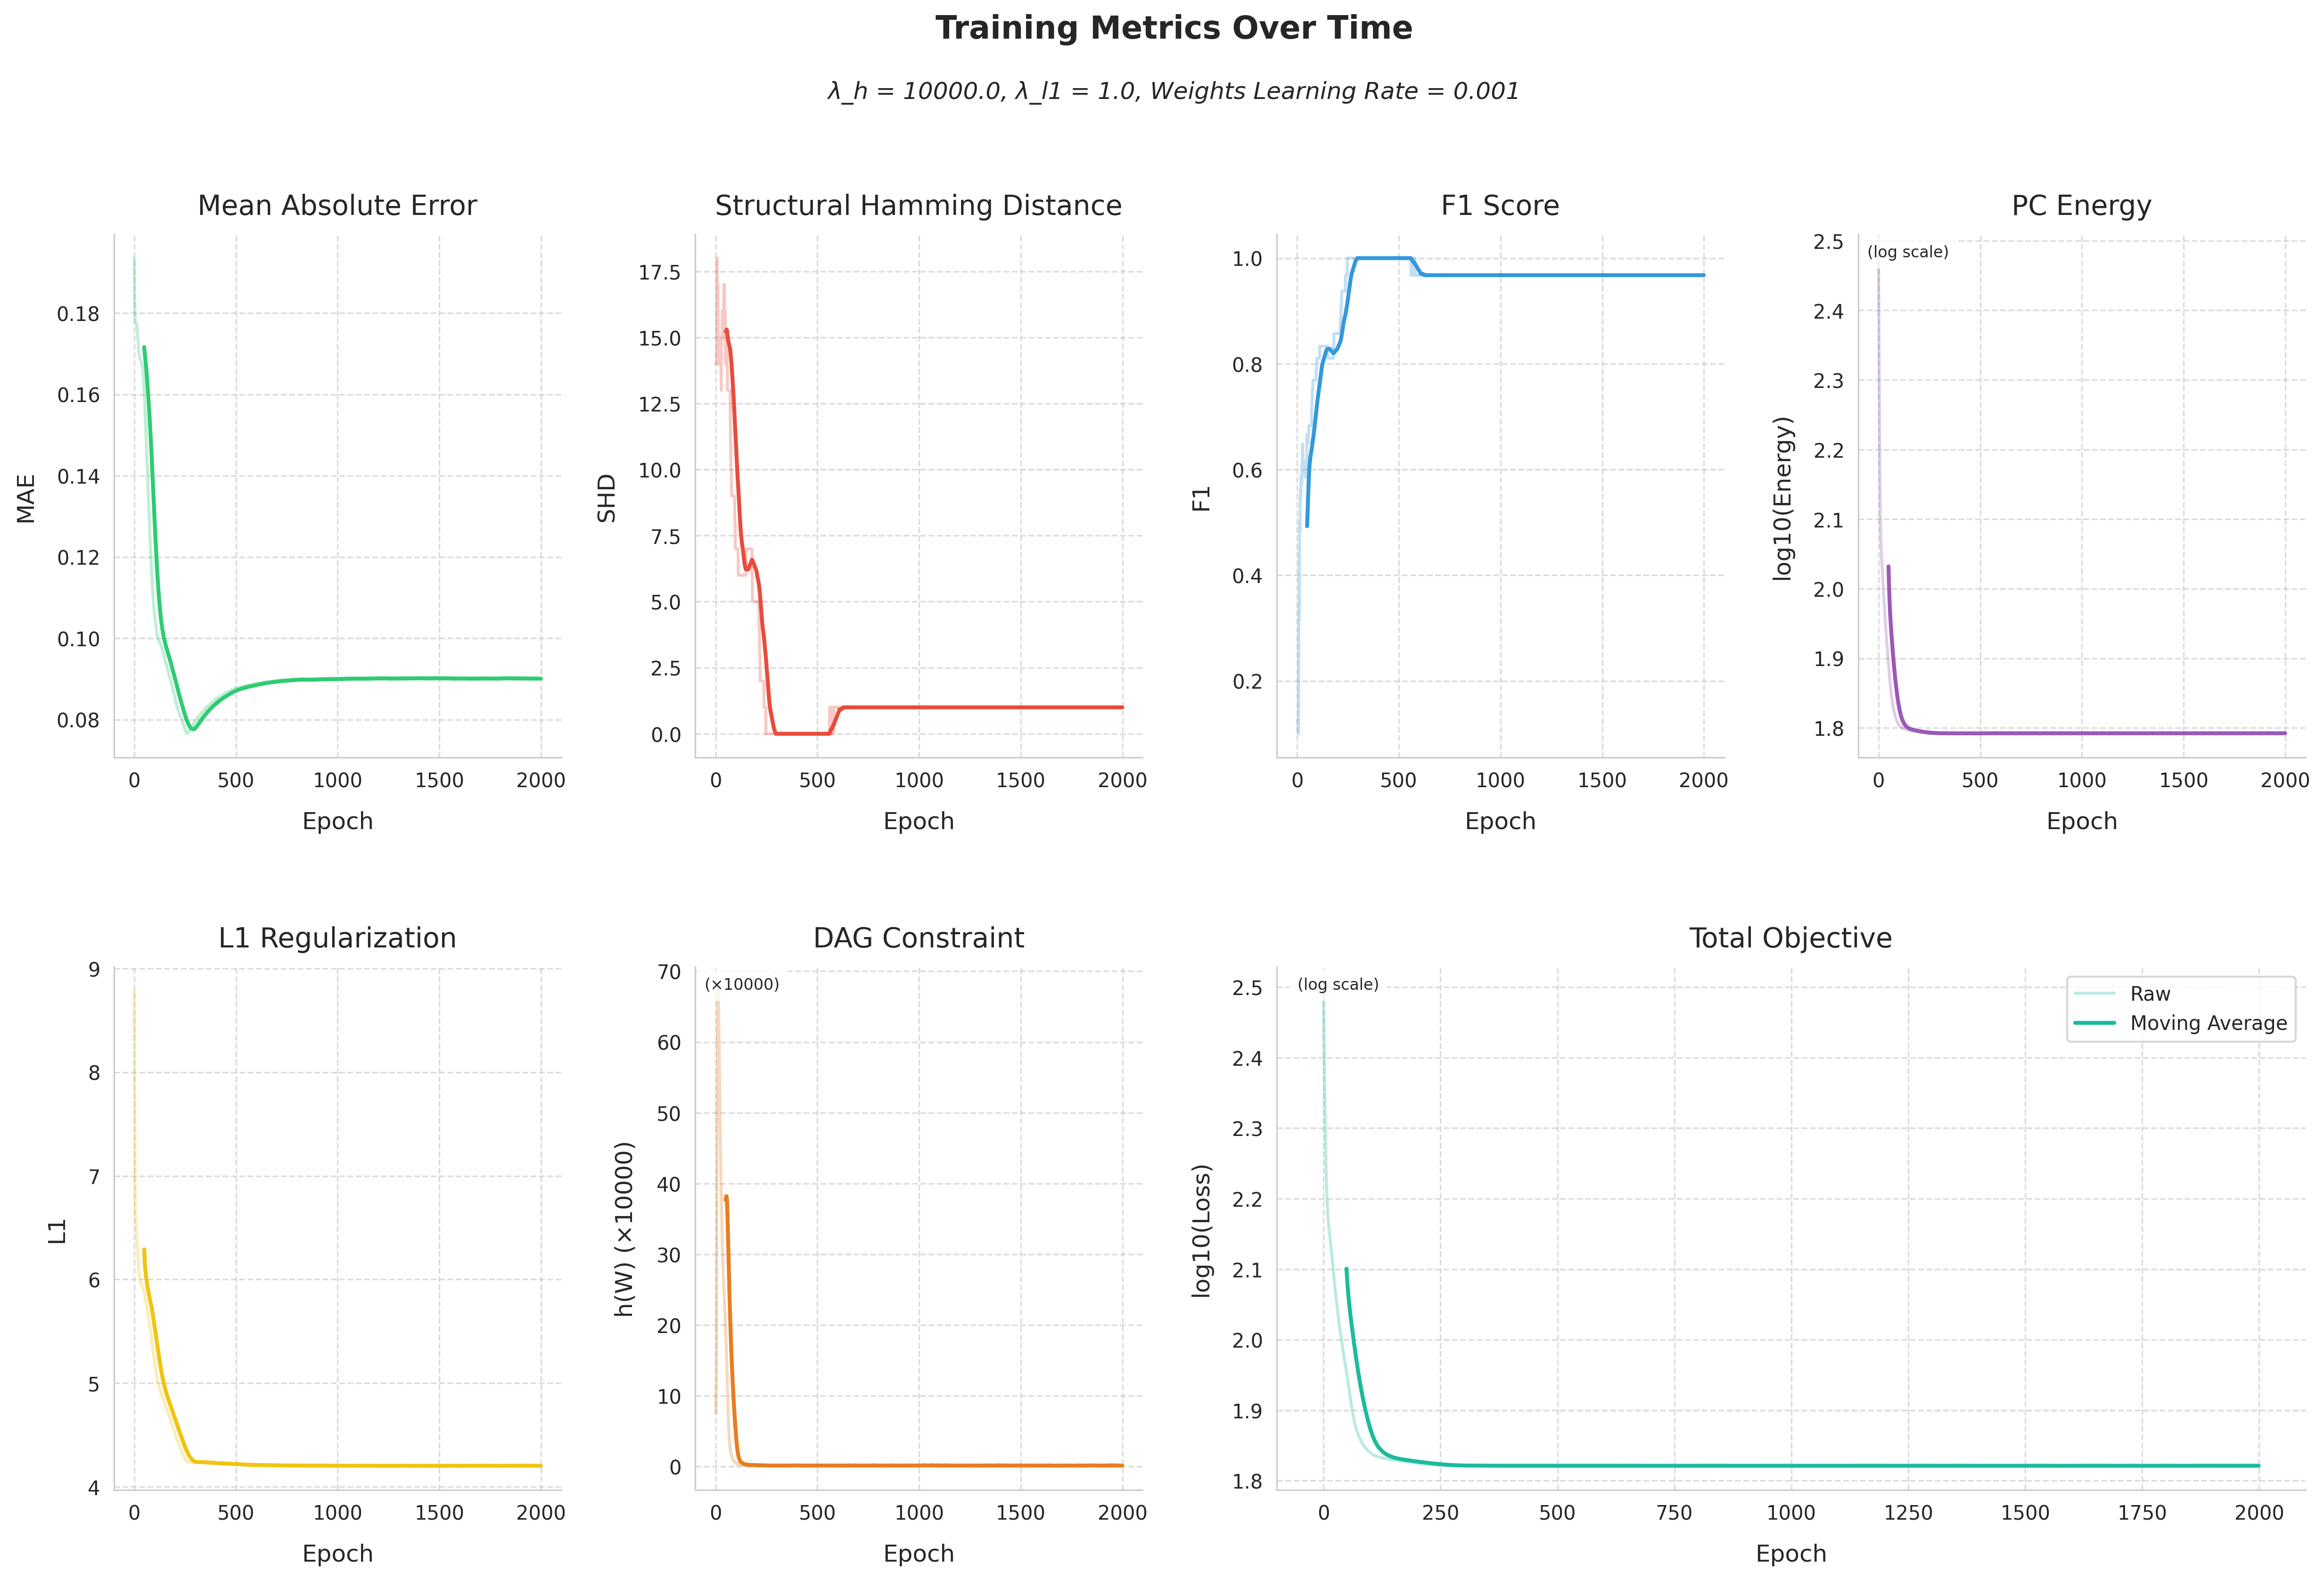

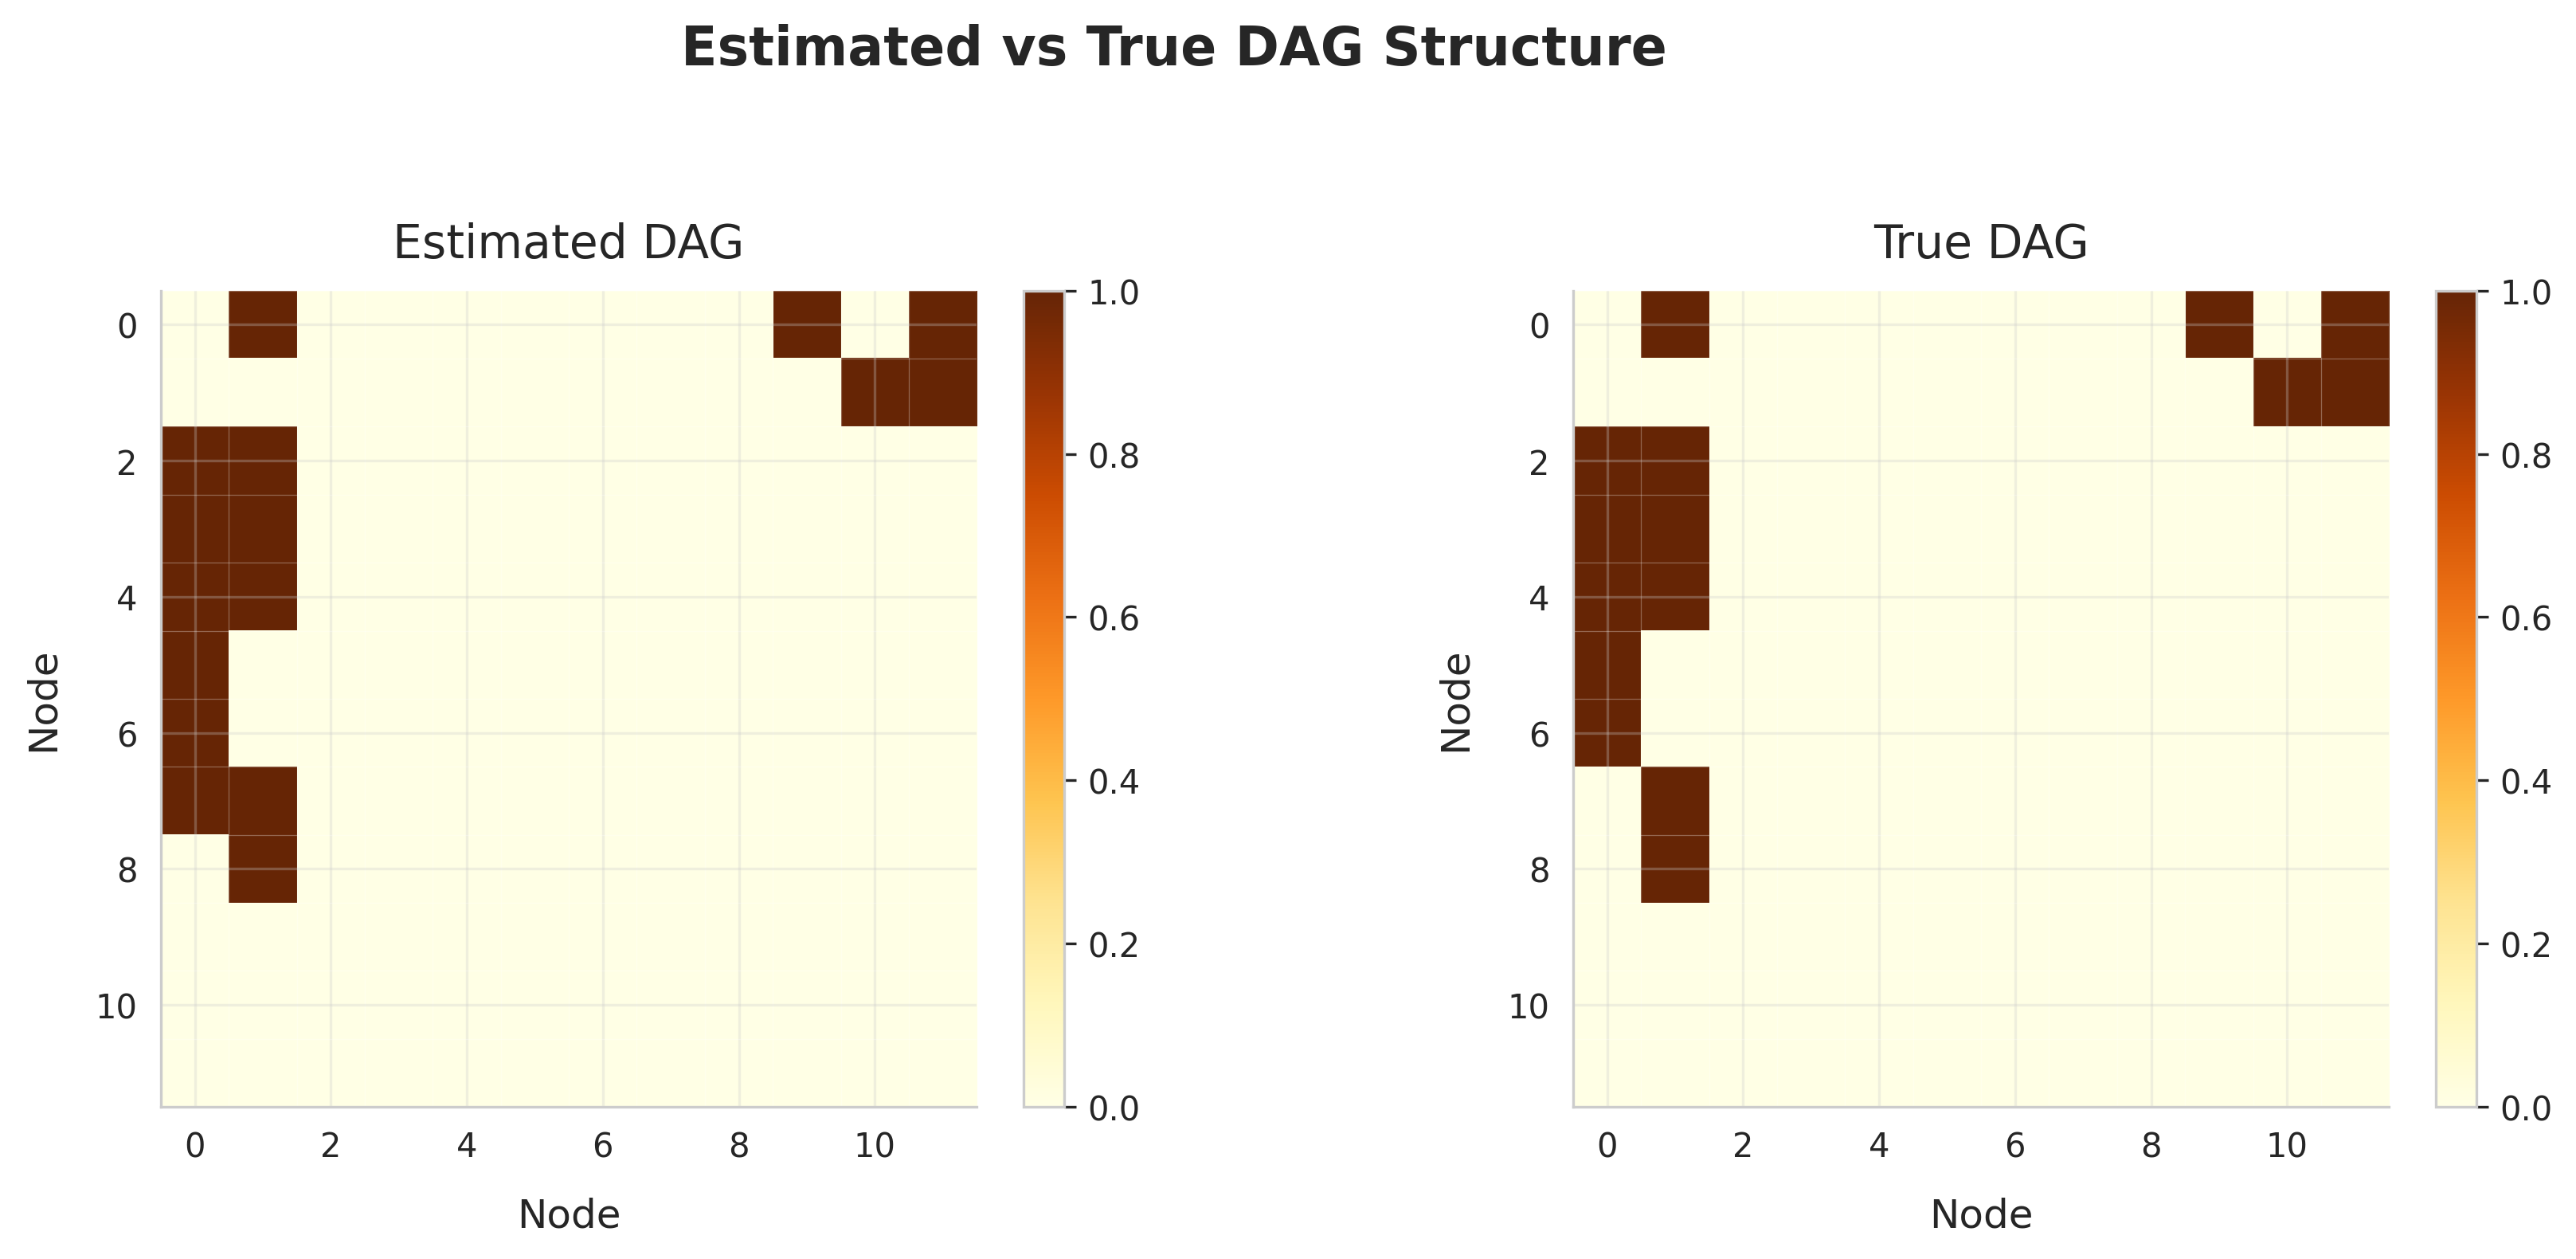

Is the estimated binary adjacency matrix a DAG? True
The h_reg term for the true weighted adjacency matrix W_true is: 0.0000
The h_reg term for the estimated weighted adjacency matrix W_est is: 0.0000
The first 5 rows and columns of the estimated weighted adjacency matrix W_est
[[ 0.      2.1494  0.     -0.     -0.0001]
 [ 0.      0.     -0.0001  0.0001 -0.    ]
 [-1.6518 -1.6804  0.     -0.0963 -0.0011]
 [-2.8371  2.0367 -0.0021  0.      0.0015]
 [-1.8661 -1.6817 -0.0705 -0.0809  0.    ]]


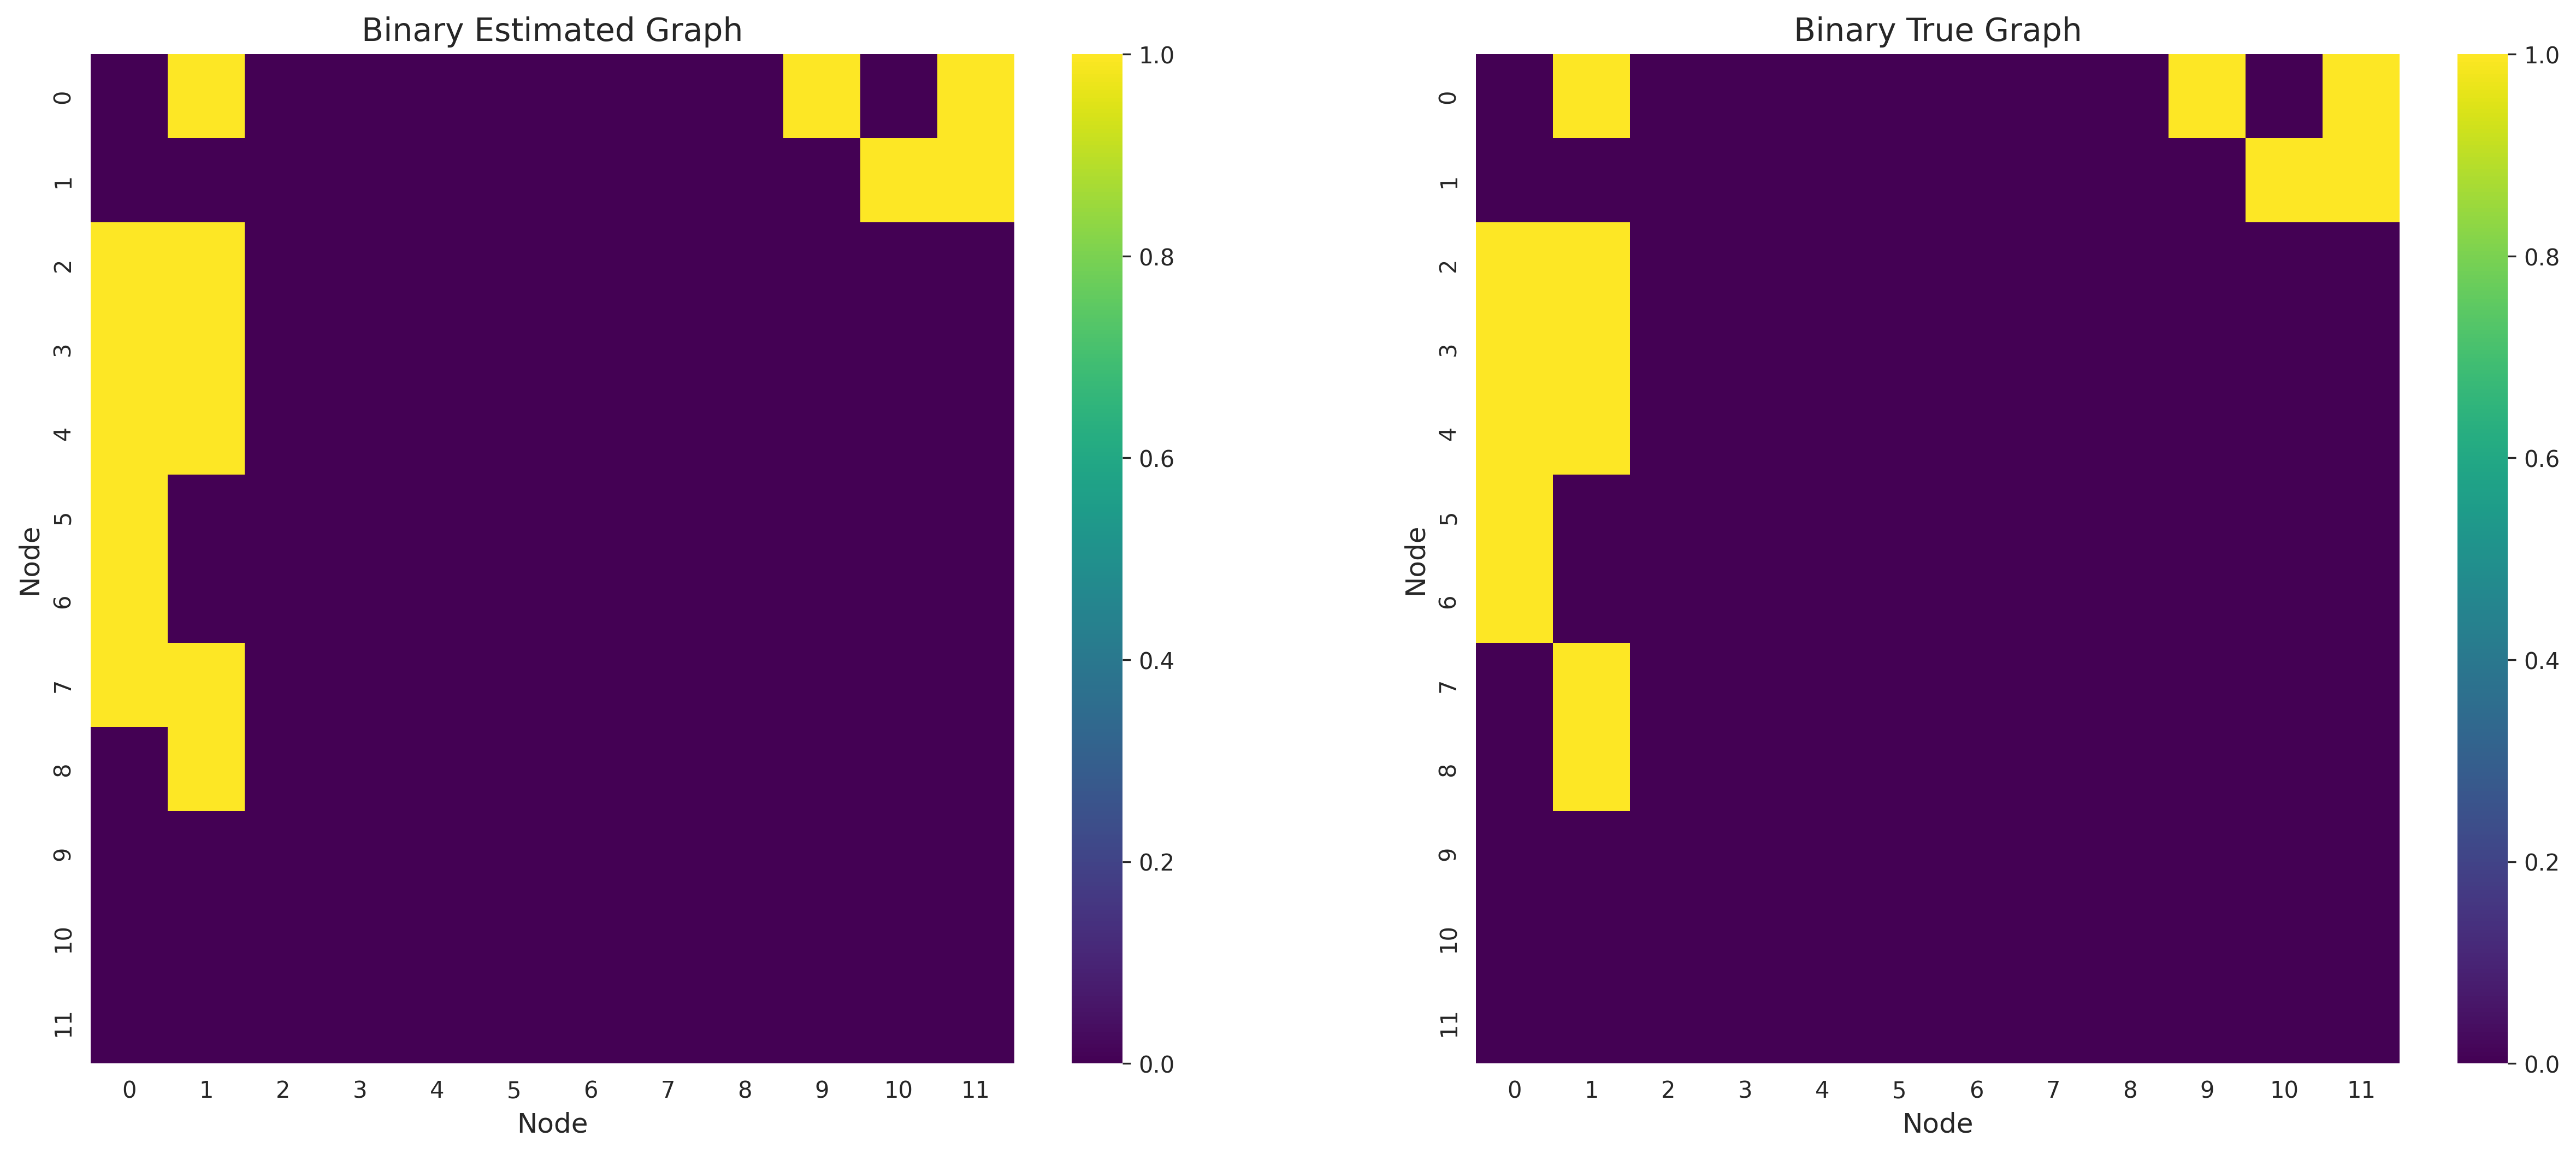

The number of edges in the true graph: 15.0
The number of edges in the estimated graph: 16


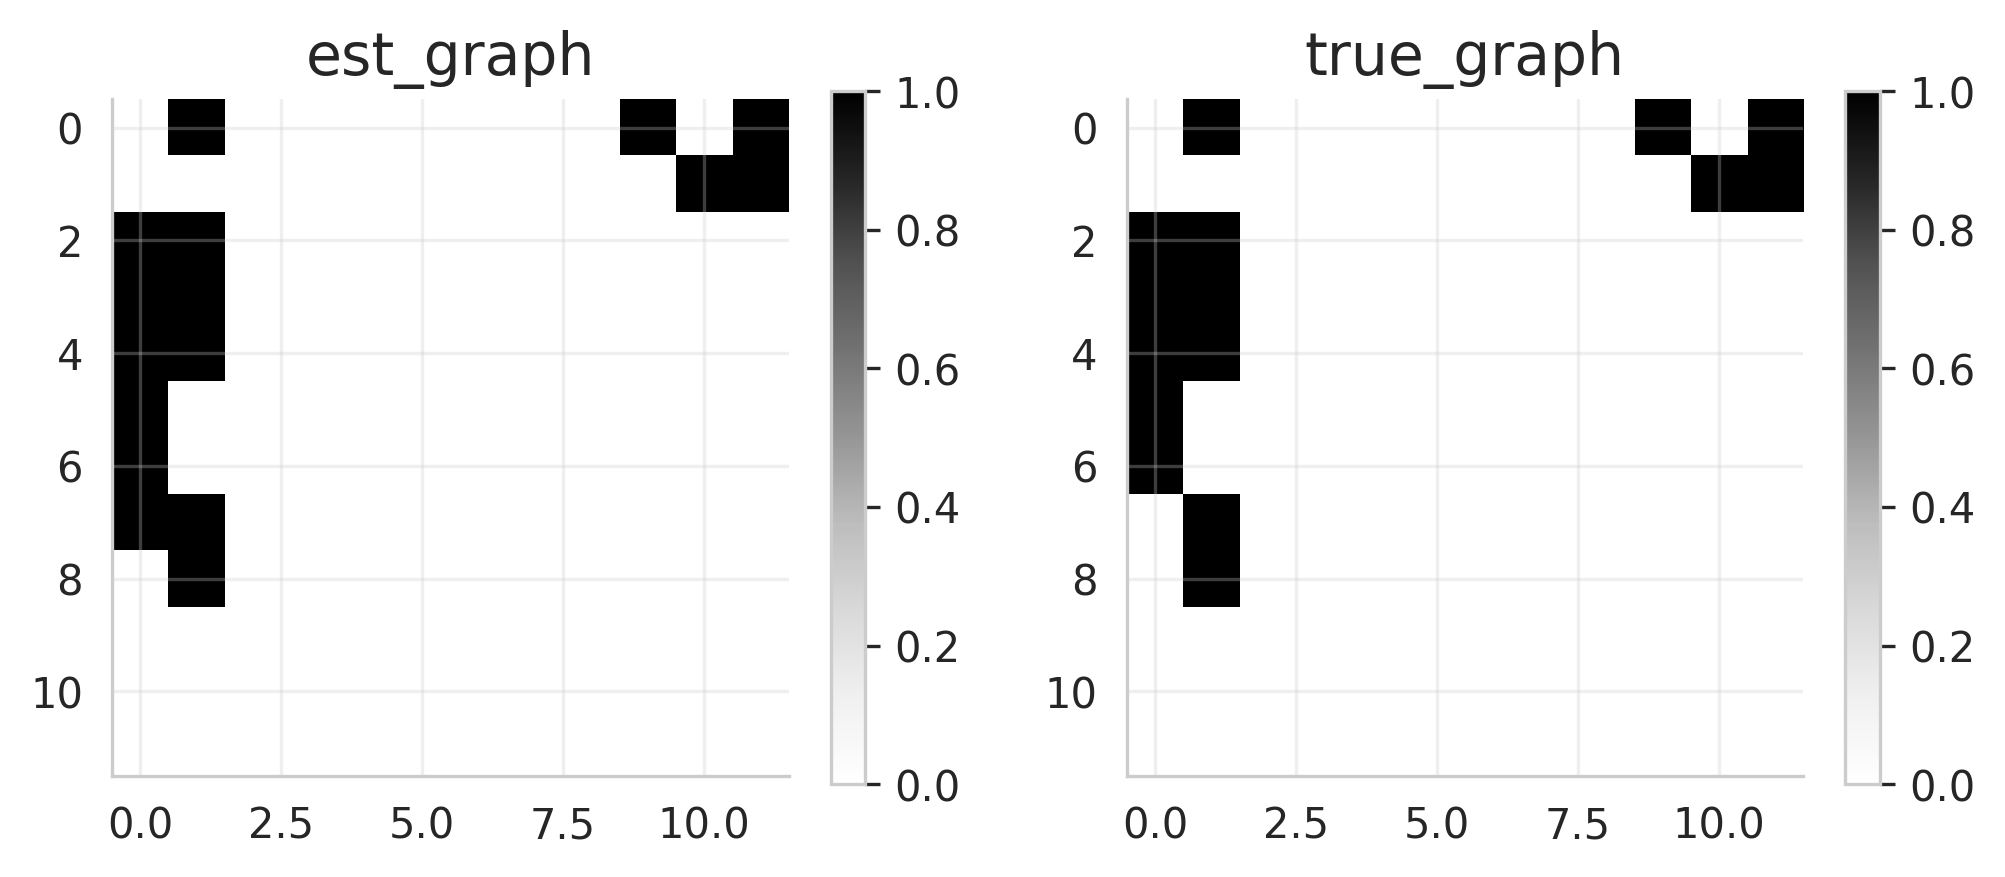

{'fdr': 0.0625, 'tpr': 1.0, 'fpr': 0.0196, 'shd': 1, 'nnz': 16, 'precision': 0.9375, 'recall': 1.0, 'F1': 0.9677, 'gscore': 0.9333}


In [11]:
# Define experiment name
exp_name = f"bs_{batch_size}_lrw_{w_learning_rate}_lrh_{h_learning_rate}_lamh_{lam_h}_laml1_{lam_l1}_epochs_{nm_epochs}"

# Create subdirectory in linear folder with the name stored in exp_name
save_path = os.path.join('plots/linear_mixed_disc_x0', exp_name)
os.makedirs(save_path, exist_ok=True)

# Reset to default style and set seaborn style
plt.style.use('default')
sns.set_style("whitegrid")

# Update matplotlib parameters
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Create a figure and subplots using GridSpec
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

# Adjust layout to make more room for title and subtitle
plt.subplots_adjust(top=0.85, hspace=0.4, wspace=0.3)

# Create axes
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax03 = fig.add_subplot(gs[0, 3])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
ax12 = fig.add_subplot(gs[1, 2:])
# ax12 spans two columns

axes = [ax00, ax01, ax02, ax03, ax10, ax11, ax12]

# Plot configurations
plot_configs = [
    {'metric': MAEs, 'title': 'Mean Absolute Error', 'ylabel': 'MAE', 'color': '#2ecc71', 'ax': ax00},
    {'metric': SHDs, 'title': 'Structural Hamming Distance', 'ylabel': 'SHD', 'color': '#e74c3c', 'ax': ax01},
    {'metric': F1s, 'title': 'F1 Score', 'ylabel': 'F1', 'color': '#3498db', 'ax': ax02},
    {'metric': pc_energies, 'title': 'PC Energy', 'ylabel': 'Energy', 'color': '#9b59b6', 'ax': ax03},
    {'metric': l1_regs, 'title': 'L1 Regularization', 'ylabel': 'L1', 'color': '#f1c40f', 'ax': ax10},
    {'metric': h_regs, 'title': 'DAG Constraint', 'ylabel': 'h(W)', 'color': '#e67e22', 'ax': ax11},
    {'metric': objs, 'title': 'Total Objective', 'ylabel': 'Loss', 'color': '#1abc9c', 'ax': ax12}
]

# Create all subplots
for config in plot_configs:
    ax = config['ax']
    
    # Plot data with rolling average
    epochs = range(len(config['metric']))
    
    # Determine if we should use log scale and/or scaling factor
    use_log_scale = config['title'] in ['PC Energy', 'Total Objective']
    scale_factor = 1e4 if config['title'] == 'DAG Constraint' else 1
    
    # Apply scaling and/or log transform to the metric
    metric_values = np.array(config['metric'])
    if use_log_scale:
        # Add small constant to avoid log(0)
        metric_values = np.log10(np.abs(metric_values) + 1e-10)
    metric_values = metric_values * scale_factor
    
    # Plot raw data
    raw_line = ax.plot(epochs, metric_values, 
                      alpha=0.3, 
                      color=config['color'], 
                      label='Raw')
    
    # Calculate and plot rolling average
    window_size = 50
    if len(metric_values) > window_size:
        rolling_mean = np.convolve(metric_values, 
                                 np.ones(window_size)/window_size, 
                                 mode='valid')
        ax.plot(range(window_size-1, len(metric_values)), 
                rolling_mean, 
                color=config['color'], 
                linewidth=2, 
                label='Moving Average')
    
    # Customize each subplot
    ax.set_title(config['title'], pad=10)
    ax.set_xlabel('Epoch', labelpad=10)
    
    # Adjust ylabel based on transformations
    ylabel = config['ylabel']
    if use_log_scale:
        ylabel = f'log10({ylabel})'
    if scale_factor != 1:
        ylabel = f'{ylabel} (×{int(scale_factor)})'
    ax.set_ylabel(ylabel, labelpad=10)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend if it's the total objective plot
    if config['title'] == 'Total Objective':
        ax.legend(loc='upper right')
        
    # Add note about scaling if applicable
    if use_log_scale or scale_factor != 1:
        transform_text = []
        if use_log_scale:
            transform_text.append('log scale')
        if scale_factor != 1:
            transform_text.append(f'×{int(scale_factor)}')
        ax.text(0.02, 0.98, f"({', '.join(transform_text)})", 
                transform=ax.transAxes, 
                fontsize=8, 
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Add overall title and subtitle with adjusted positions
fig.suptitle('Training Metrics Over Time', 
            fontsize=16, 
            weight='bold', 
            y=0.98)

subtitle = f'λ_h = {lam_h}, λ_l1 = {lam_l1}, Weights Learning Rate = {w_learning_rate}'
fig.text(0.5, 0.93, 
         subtitle, 
         horizontalalignment='center',
         fontsize=12,
         style='italic')

# Save and show the figure as a .pdf file at the specified location
plt.savefig(os.path.join(save_path, 'training_metrics.pdf'), 
            bbox_inches='tight', 
            dpi=300)
plt.show()

# Create a separate figure for the adjacency matrices comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Use a better colormap - options:
# 'YlOrBr' - Yellow-Orange-Brown (good for sparse matrices)
# 'viridis' - Perceptually uniform, colorblind-friendly
# 'Greys' - Black and white, professional
# 'YlGnBu' - Yellow-Green-Blue, professional
cmap = 'YlOrBr'  # Choose one of the above

# Plot estimated adjacency matrix (now on the left)
im1 = ax1.imshow(compute_binary_adjacency(W), cmap=cmap, interpolation='nearest')
ax1.set_title('Estimated DAG', pad=10)
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlabel('Node', labelpad=10)
ax1.set_ylabel('Node', labelpad=10)

# Plot true adjacency matrix (now on the right)
im2 = ax2.imshow(B_true, cmap=cmap, interpolation='nearest')
ax2.set_title('True DAG', pad=10)
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_xlabel('Node', labelpad=10)
ax2.set_ylabel('Node', labelpad=10)

# Add overall title
fig.suptitle('Estimated vs True DAG Structure', 
             fontsize=16, 
             weight='bold', 
             y=1.05)

# Add grid lines to better separate the nodes
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(-.5, B_true.shape[0], 1), minor=True)
    ax.set_yticks(np.arange(-.5, B_true.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0.3)
    ax.tick_params(which="minor", bottom=False, left=False)

# Improve layout
plt.tight_layout()

# Save the comparison plot as a .pdf file at the specified location
plt.savefig(os.path.join(save_path, 'dag_comparison.pdf'), 
            bbox_inches='tight', 
            dpi=300,
            facecolor='white',
            edgecolor='none')
plt.show()

# %%
# Now use a threshold of 0.3 to binarize the weighted adjacency matrix W
W_est = np.array(model.get_W())
B_est = compute_binary_adjacency(W_est, threshold=0.3)

# %%
# Check if B_est is indeed a DAG
def is_dag(adjacency_matrix):
    """
    Check if a given adjacency matrix represents a Directed Acyclic Graph (DAG).
    
    Parameters:
        adjacency_matrix (numpy.ndarray): A square matrix representing the adjacency of a directed graph.
        
    Returns:
        bool: True if the graph is a DAG, False otherwise.
    """
    # Create a directed graph from the adjacency matrix
    graph = nx.DiGraph(adjacency_matrix)
    
    # Check if the graph is a DAG
    return nx.is_directed_acyclic_graph(graph)

# Check if the estimated binary adjacency matrix B_est is a DAG
is_dag_B_est = is_dag(B_est)
print(f"Is the estimated binary adjacency matrix a DAG? {is_dag_B_est}")


# Compute the h_reg term for the true weighted adjacency matrix W_true
h_reg_true = compute_h_reg(W_true)
print(f"The h_reg term for the true weighted adjacency matrix W_true is: {h_reg_true:.4f}")

# Compute the h_reg term for the estimated weighted adjacency matrix W_est
h_reg_est = compute_h_reg(W_est)
print(f"The h_reg term for the estimated weighted adjacency matrix W_est is: {h_reg_est:.4f}")

# print first 5 rows and columsn of W_est and round values to 4 decimal places and show as non-scientific notation
np.set_printoptions(precision=4, suppress=True)

print("The first 5 rows and columns of the estimated weighted adjacency matrix W_est\n{}".format(W_est[:5, :5]))

# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(true_matrix=B_true, est_matrix=B_est, save_path=os.path.join(save_path, 'adjacency_matrices.png'))

# print the number of edges in the true graph and the estimated graph
print(f"The number of edges in the true graph: {np.sum(B_true)}")
print(f"The number of edges in the estimated graph: {np.sum(B_est)}")

# %%
# plot est_dag and true_dag
GraphDAG(B_est, B_true, save_name=os.path.join(save_path, 'est_dag_true_dag.png'))
# calculate accuracy
met_pcx = MetricsDAG(B_est, B_true)
print(met_pcx.metrics)

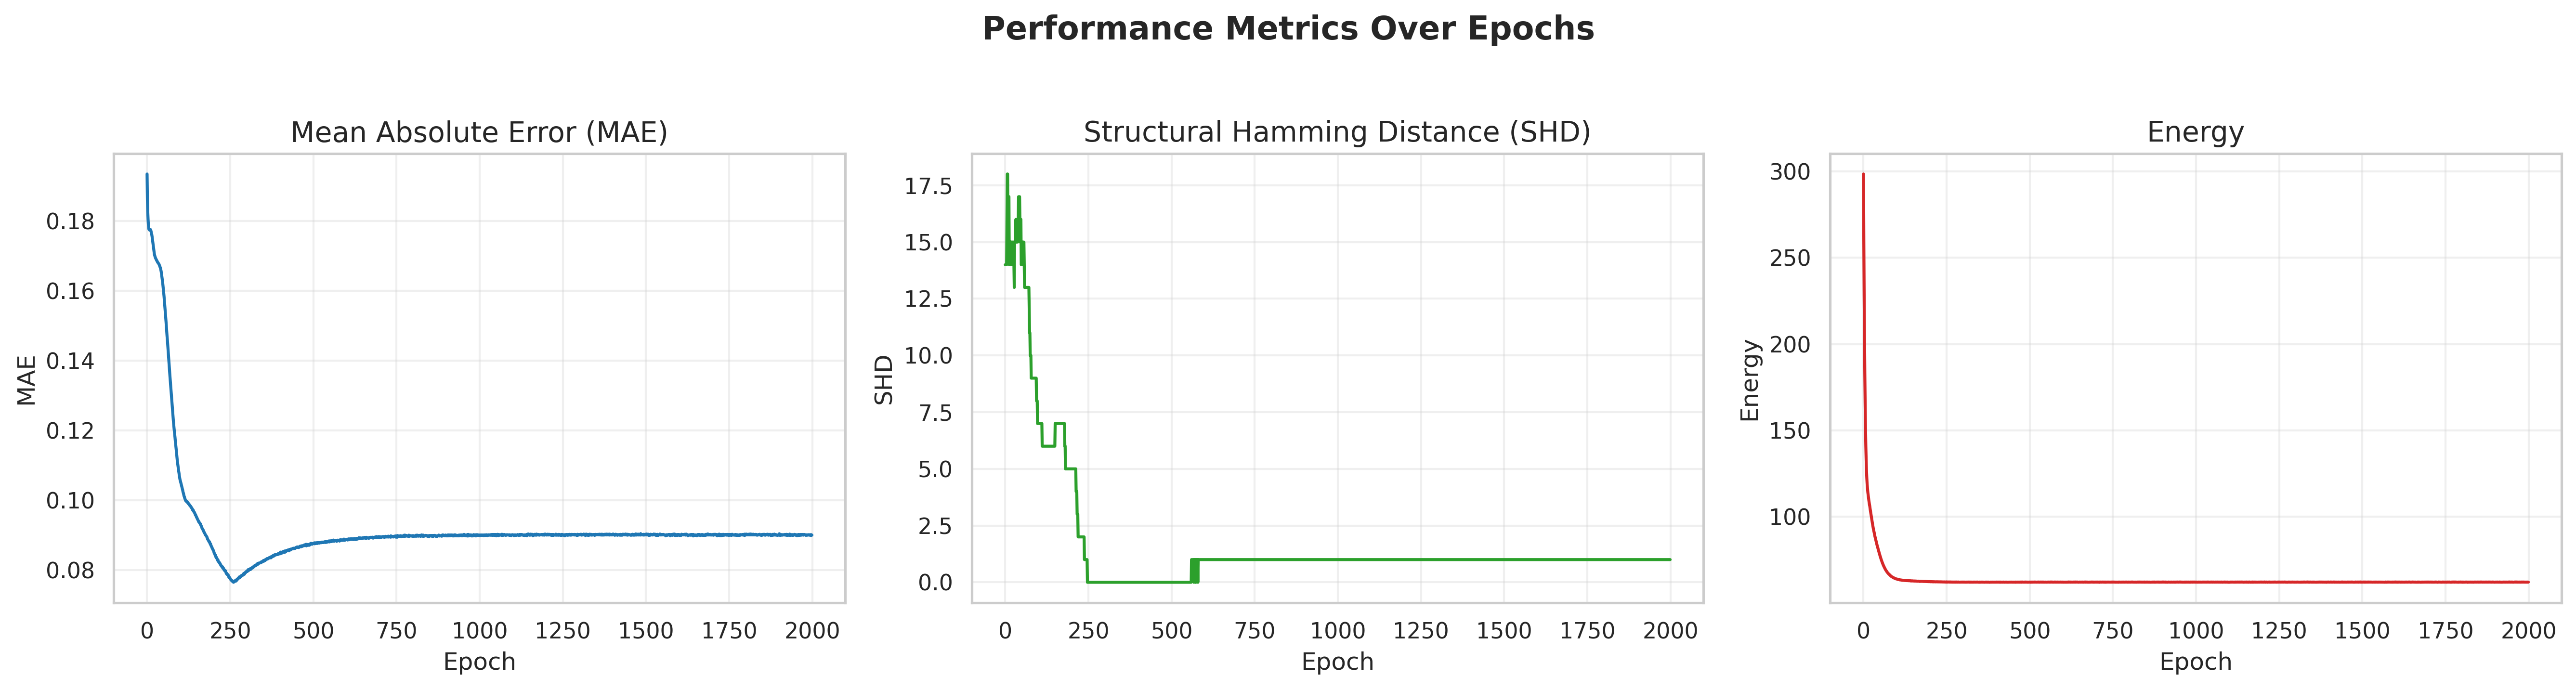

In [12]:
# Set the style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("tab10")

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjusting layout to 1 row and 3 columns
fig.suptitle('Performance Metrics Over Epochs', fontsize=16, weight='bold')

# Plot the MAE
sns.lineplot(x=range(len(MAEs)), y=MAEs, ax=axs[0], color=palette[0])
axs[0].set_title("Mean Absolute Error (MAE)", fontsize=14)
axs[0].set_xlabel("Epoch", fontsize=12)
axs[0].set_ylabel("MAE", fontsize=12)
axs[0].grid(True)

# Plot the SHD
sns.lineplot(x=range(len(SHDs)), y=SHDs, ax=axs[1], color=palette[2])
axs[1].set_title("Structural Hamming Distance (SHD)", fontsize=14)
axs[1].set_xlabel("Epoch", fontsize=12)
axs[1].set_ylabel("SHD", fontsize=12)
axs[1].grid(True)

# Plot the Energy
sns.lineplot(x=range(len(pc_energies)), y=pc_energies, ax=axs[2], color=palette[3])
axs[2].set_title("Energy", fontsize=14)
axs[2].set_xlabel("Epoch", fontsize=12)
axs[2].set_ylabel("Energy", fontsize=12)
axs[2].grid(True)

# Improve layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

In [13]:
# print first 5 rows and columsn of W_est and round values to 4 decimal places and show as non-scientific notation
np.set_printoptions(precision=4, suppress=True)

print("The first 4 rows and columns of the estimated weighted adjacency matrix W_est\n{}".format(W_est[:11, :11]))

The first 4 rows and columns of the estimated weighted adjacency matrix W_est
[[ 0.      2.1494  0.     -0.     -0.0001  0.     -0.     -0.0002 -0.1087
   1.261  -0.003 ]
 [ 0.      0.     -0.0001  0.0001 -0.     -0.0001 -0.0001 -0.0003 -0.002
  -0.2099  1.1225]
 [-1.6518 -1.6804  0.     -0.0963 -0.0011 -0.0901 -0.117  -0.1218 -0.0665
   0.1788  0.1302]
 [-2.8371  2.0367 -0.0021  0.      0.0015  0.0016 -0.0033 -0.0007 -0.0122
  -0.0003  0.0305]
 [-1.8661 -1.6817 -0.0705 -0.0809  0.     -0.0037 -0.0511 -0.0997 -0.1134
   0.1919  0.162 ]
 [-1.8941  0.1896 -0.0035 -0.047  -0.1234  0.     -0.095  -0.0765 -0.1062
   0.1339  0.1528]
 [-4.169   0.0883 -0.0013 -0.0034 -0.0003 -0.0019  0.     -0.0011 -0.001
   0.0618  0.0728]
 [ 0.3243 -0.9483 -0.0013 -0.0768 -0.0014 -0.0026 -0.0703  0.     -0.0161
   0.0918  0.0888]
 [ 0.0002 -1.1772  0.0006 -0.0008  0.0001  0.0001 -0.0004  0.0005  0.
   0.0281  0.0014]
 [ 0.0002  0.0018  0.0001  0.     -0.     -0.      0.     -0.0004 -0.0001
   0.      0.0126

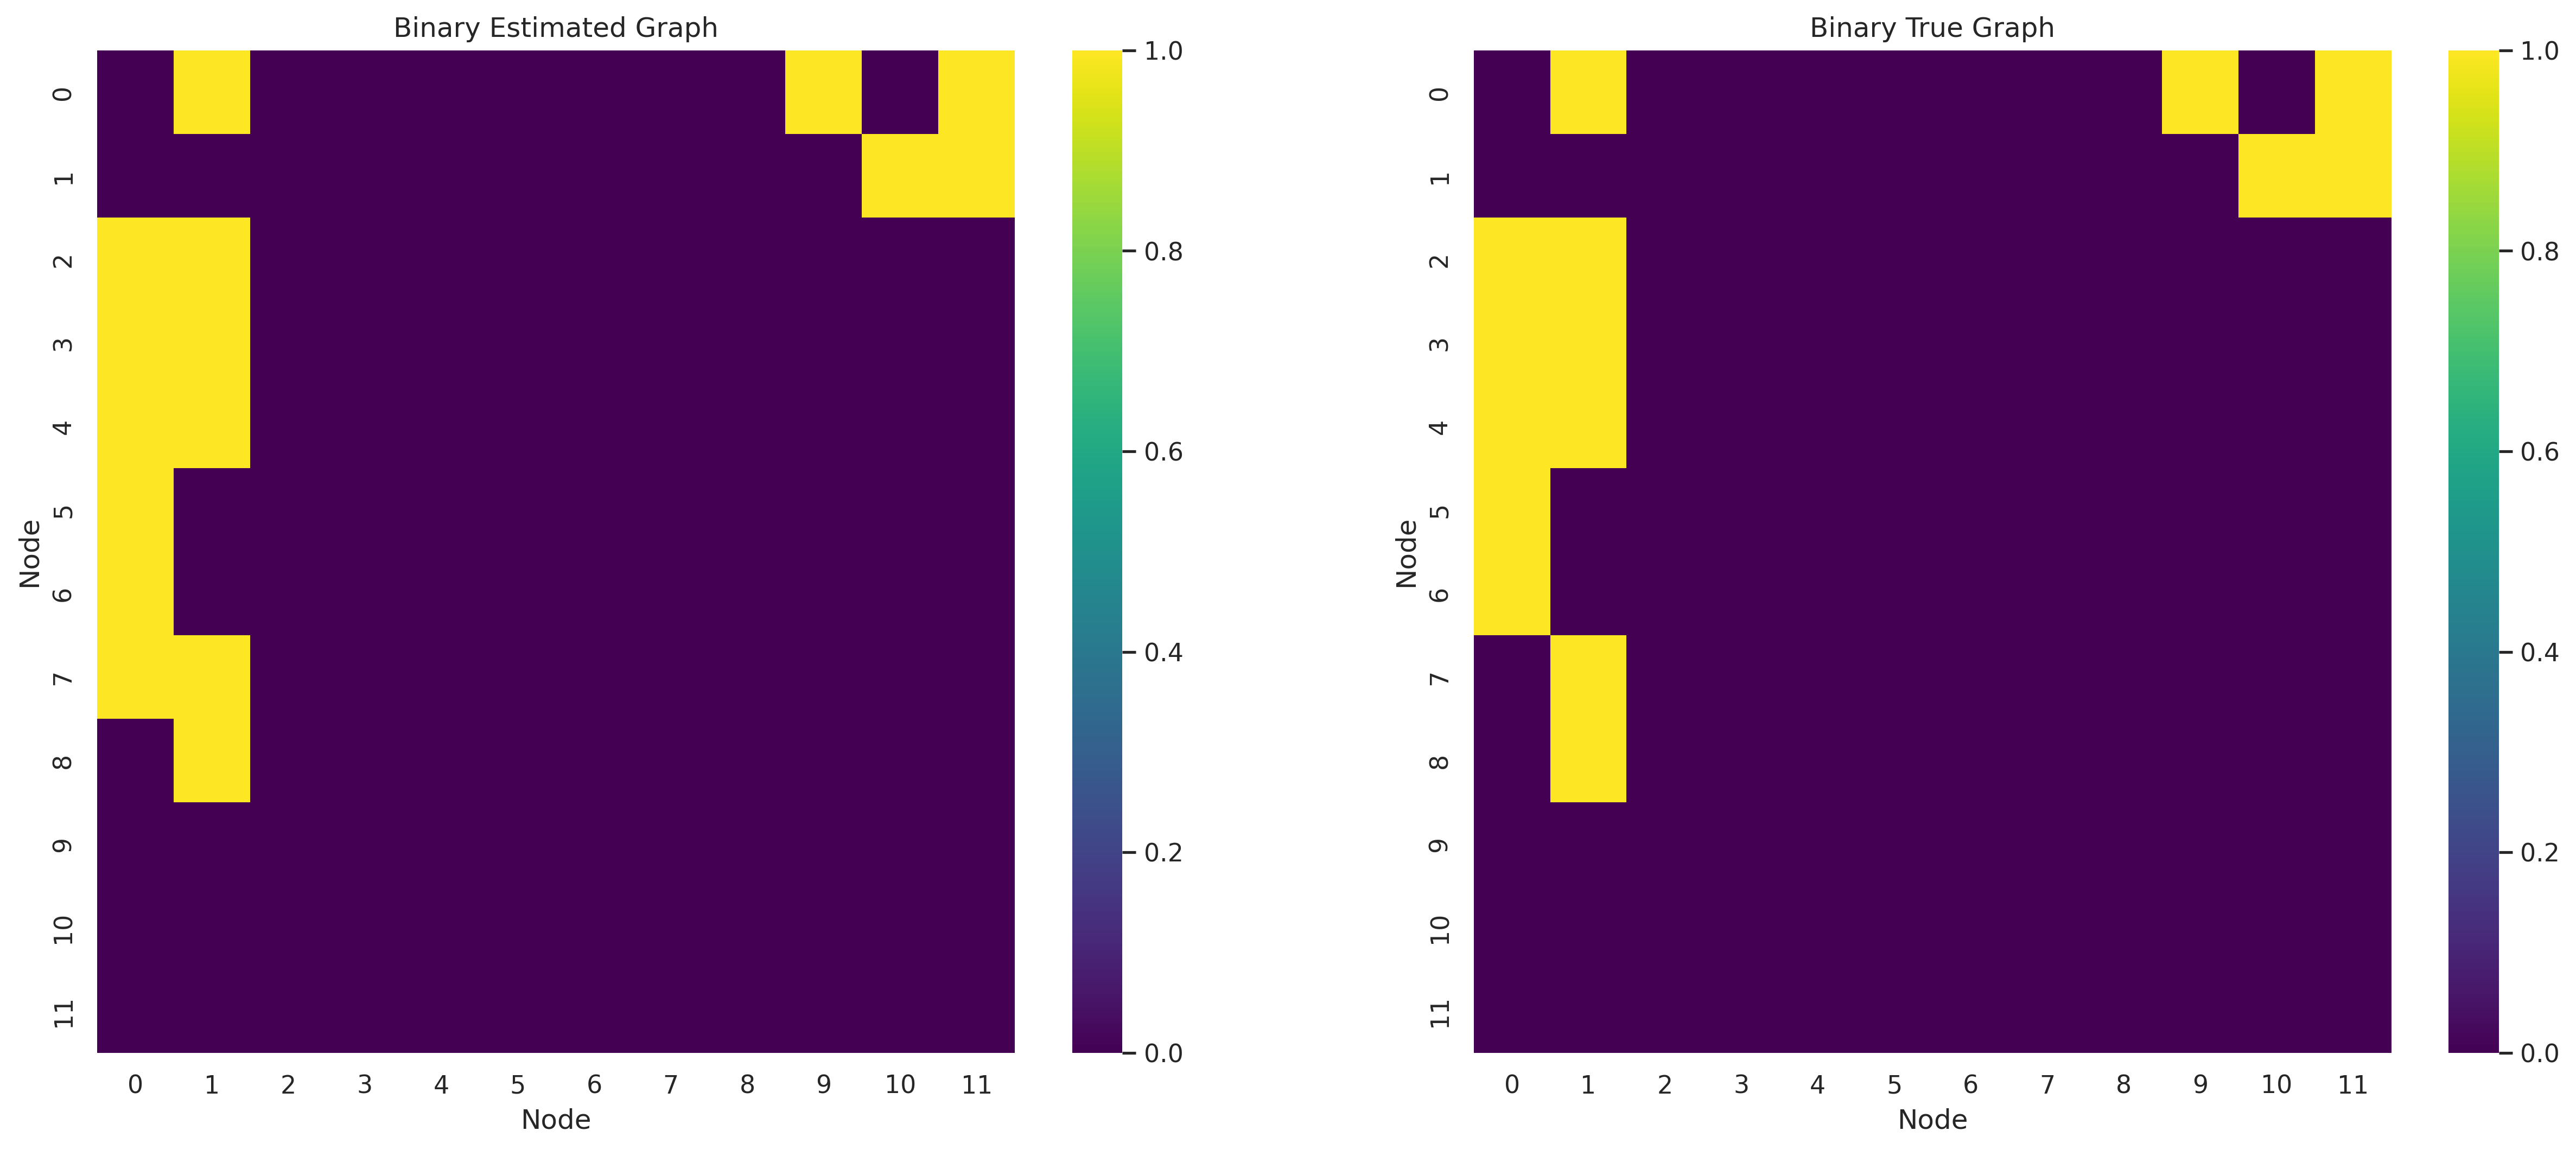

The number of edges in the true graph: 15.0
The number of edges in the estimated graph: 16


In [14]:
# now show the adjacency matrix of the true graph and the estimated graph side by side
plot_adjacency_matrices(B_true, B_est)

# print the number of edges in the true graph and the estimated graph
print(f"The number of edges in the true graph: {np.sum(B_true)}")
print(f"The number of edges in the estimated graph: {np.sum(B_est)}")

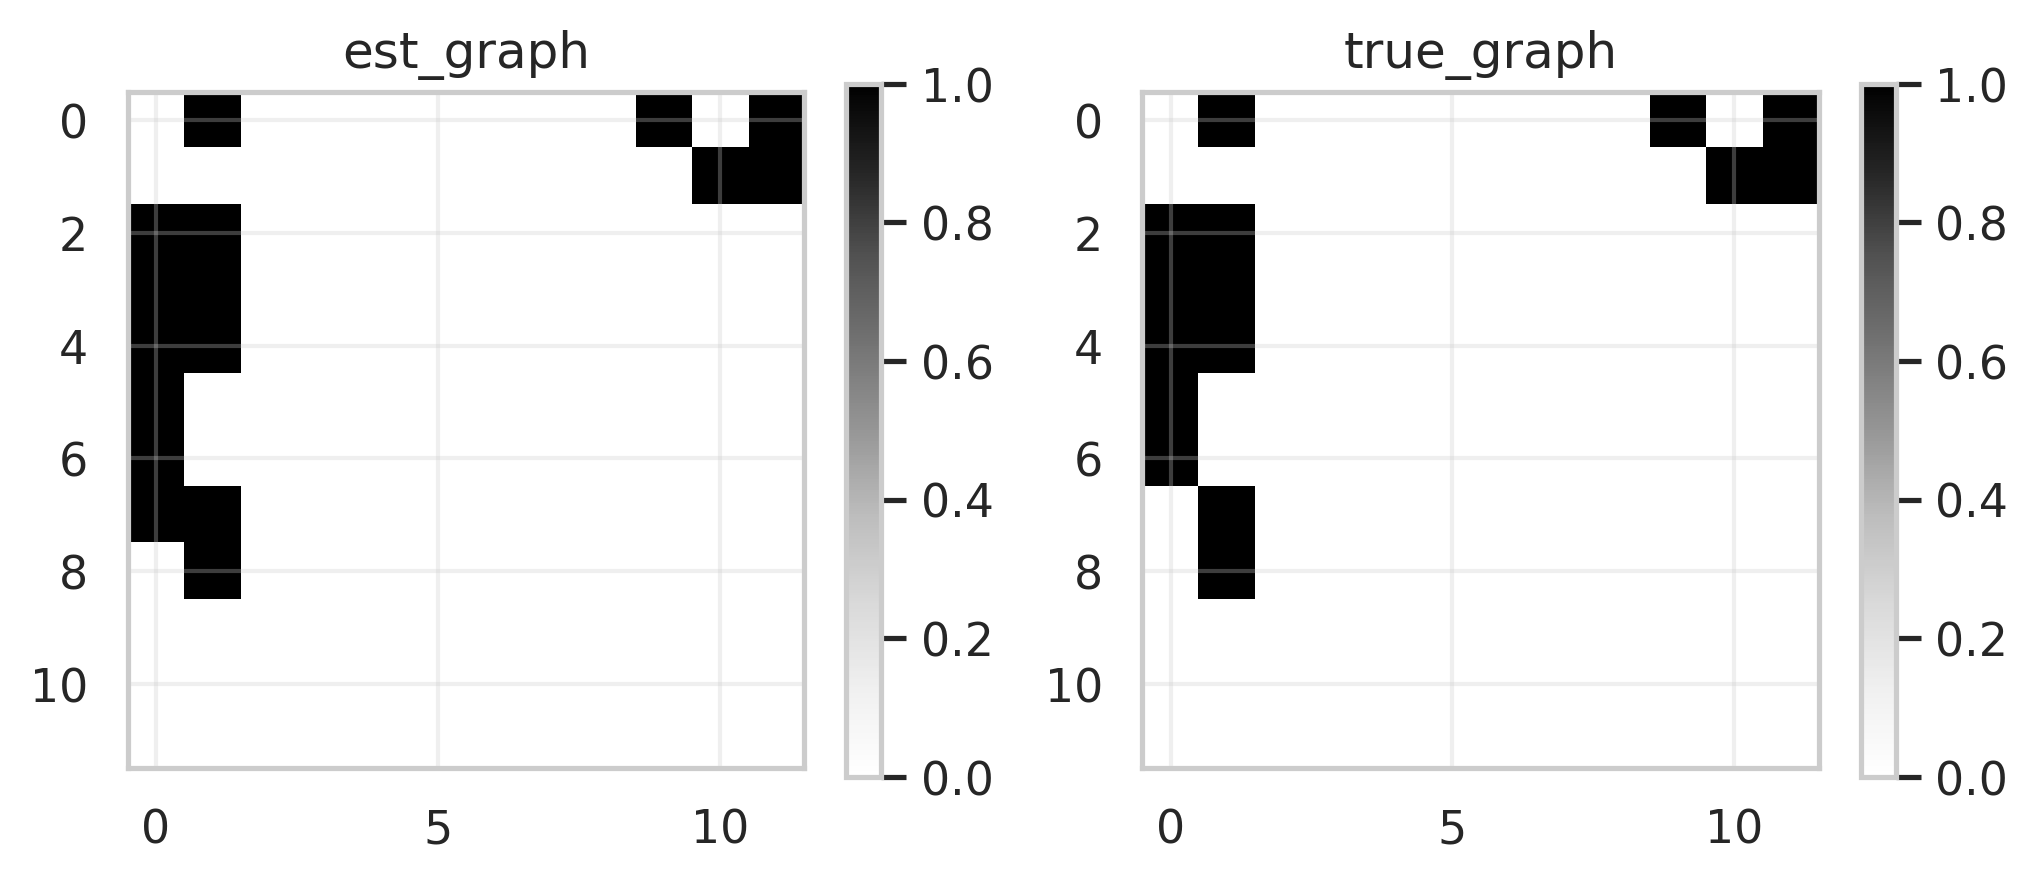

{'fdr': 0.0625, 'tpr': 1.0, 'fpr': 0.0196, 'shd': 1, 'nnz': 16, 'precision': 0.9375, 'recall': 1.0, 'F1': 0.9677, 'gscore': 0.9333}
bs_128_lrw_0.001_lrh_0.0001_lamh_10000.0_laml1_1.0_epochs_2000


In [15]:
# plot est_dag and true_dag
GraphDAG(B_est, B_true)
# calculate accuracy
met_pcax = MetricsDAG(B_est, B_true)
print(met_pcax.metrics)

# print experiment name
print(exp_name)

2025-02-10 08:52:03,477 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:229] - INFO: [start]: n=4000, d=12, iter_=200, h_=1e-05, rho_=1e+16
2025-02-10 08:52:08,116 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:247] - INFO: [iter 0] h=2.662e-01, loss=16874744306153247218315953810618133651451143978564175527936.000, rho=1.0e+00
2025-02-10 08:52:08,167 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:247] - INFO: [iter 1] h=2.067e-01, loss=2.874, rho=1.0e+00
2025-02-10 08:52:08,243 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packages/castle/algorithms/gradient/notears/linear.py[line:247] - INFO: [iter 1] h=1.230e-01, loss=3.193, rho=1.0e+01
2025-02-10 08:52:08,381 - /share/amine.mcharrak/miniconda3/envs/pcax24/lib/python3.10/site-packag

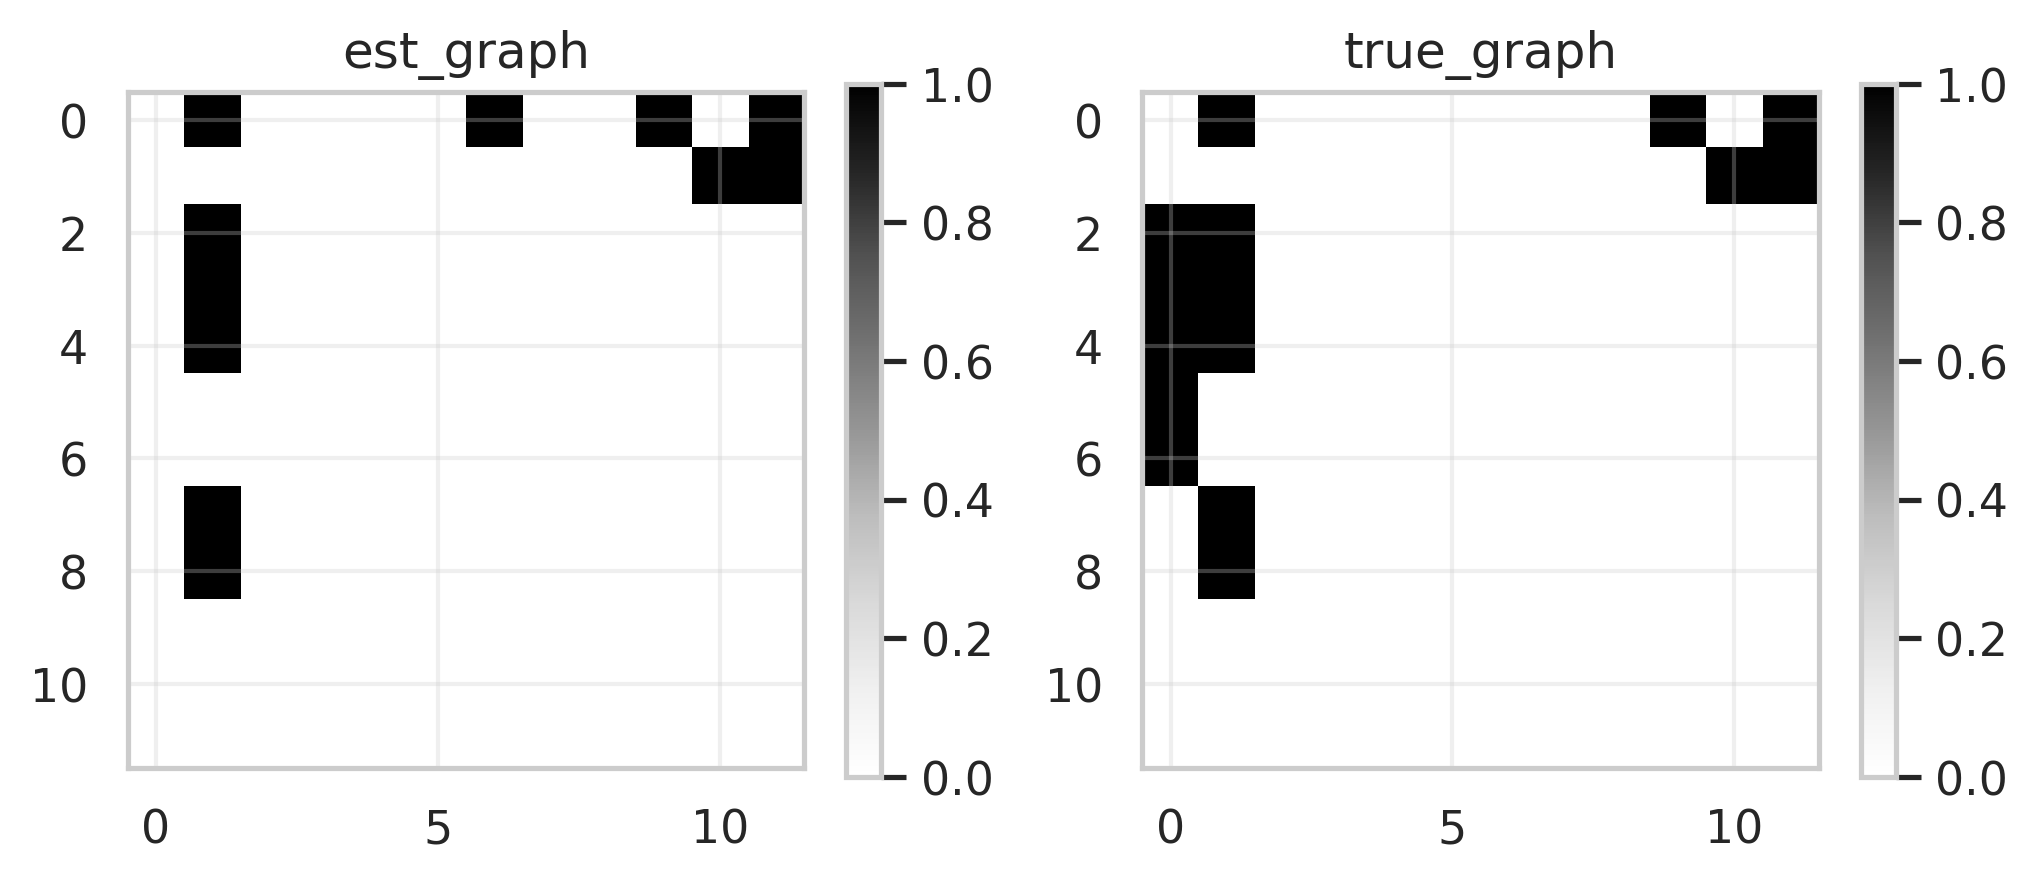

{'fdr': 0.0909, 'tpr': 0.6667, 'fpr': 0.0196, 'shd': 5, 'nnz': 11, 'precision': 0.9091, 'recall': 0.6667, 'F1': 0.7692, 'gscore': 0.6}


In [16]:
# notears learn
nt = Notears(lambda1=0.1, h_tol=1e-5, max_iter=200, loss_type='l2', seed=seed) # takes 8 seconds, final loss @ 4.1
#nt = Notears(lambda1=0.1, h_tol=1e-5, max_iter=200, loss_type='laplace', seed=seed) # takes 16 seconds, final loss @ 8.2
#nt = Notears(lambda1=0.1, h_tol=1e-3, max_iter=100, loss_type='logistic', seed=seed) # takes over 5 minutes, final loss @ 245
#nt = Notears(lambda1=0.1, h_tol=1se-3, max_iter=100, loss_type='poisson', seed=seed)
nt.learn(X)

# plot est_dag and true_dag
GraphDAG(nt.causal_matrix, B_true)

# calculate accuracy
nt_met = MetricsDAG(nt.causal_matrix, B_true)
print(nt_met.metrics)

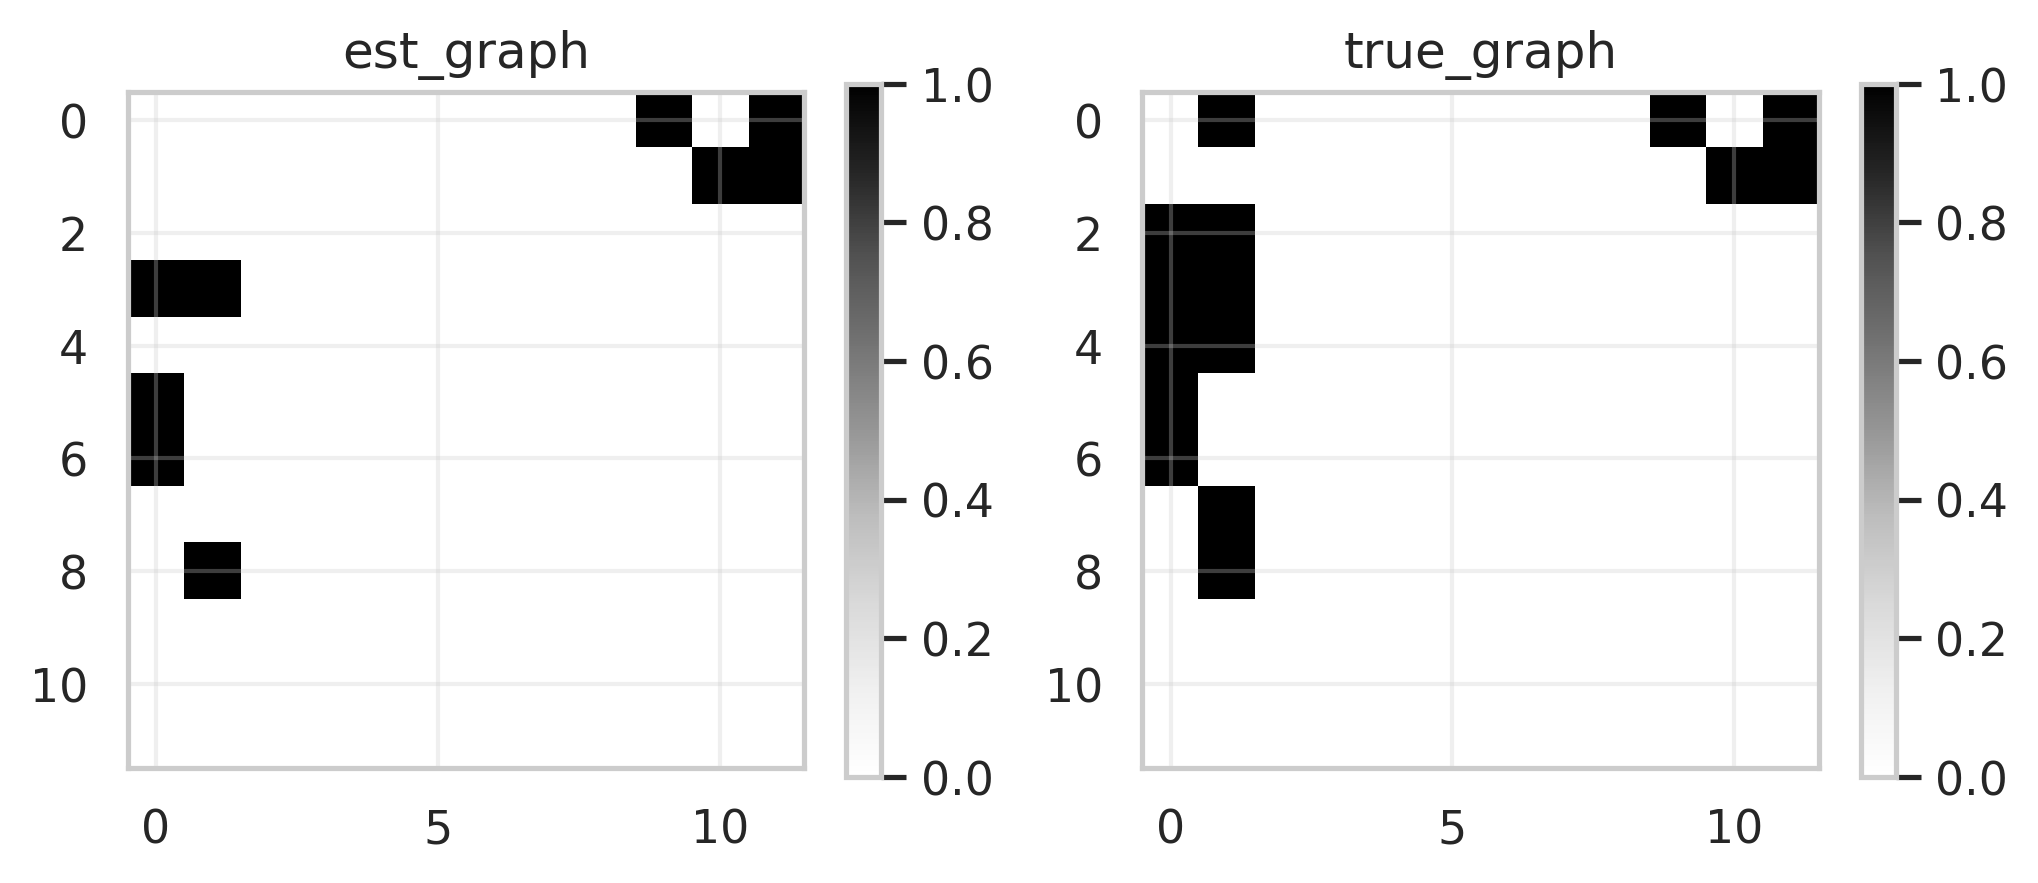

{'fdr': 0.0, 'tpr': 0.6, 'fpr': 0.0, 'shd': 6, 'nnz': 9, 'precision': 1.0, 'recall': 0.6, 'F1': 0.75, 'gscore': 0.6}


In [17]:
# Peter & Clark (PC)
# A variant of PC-algorithm, one of [`original`, `stable`, `parallel`]
pc = PC(variant='parallel', alpha=0.03, ci_test='fisherz', random_state=seed) # F1 of 75%
#pc = PC(variant='stable', alpha=0.03) # F1 of 66%
#pc = PC(variant='original', alpha=0.03) # F1 of 55%
pc.learn(X)

# plot est_dag and true_dag
GraphDAG(pc.causal_matrix, B_true)

# calculate accuracy
pc_met = MetricsDAG(pc.causal_matrix, B_true)
print(pc_met.metrics)

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


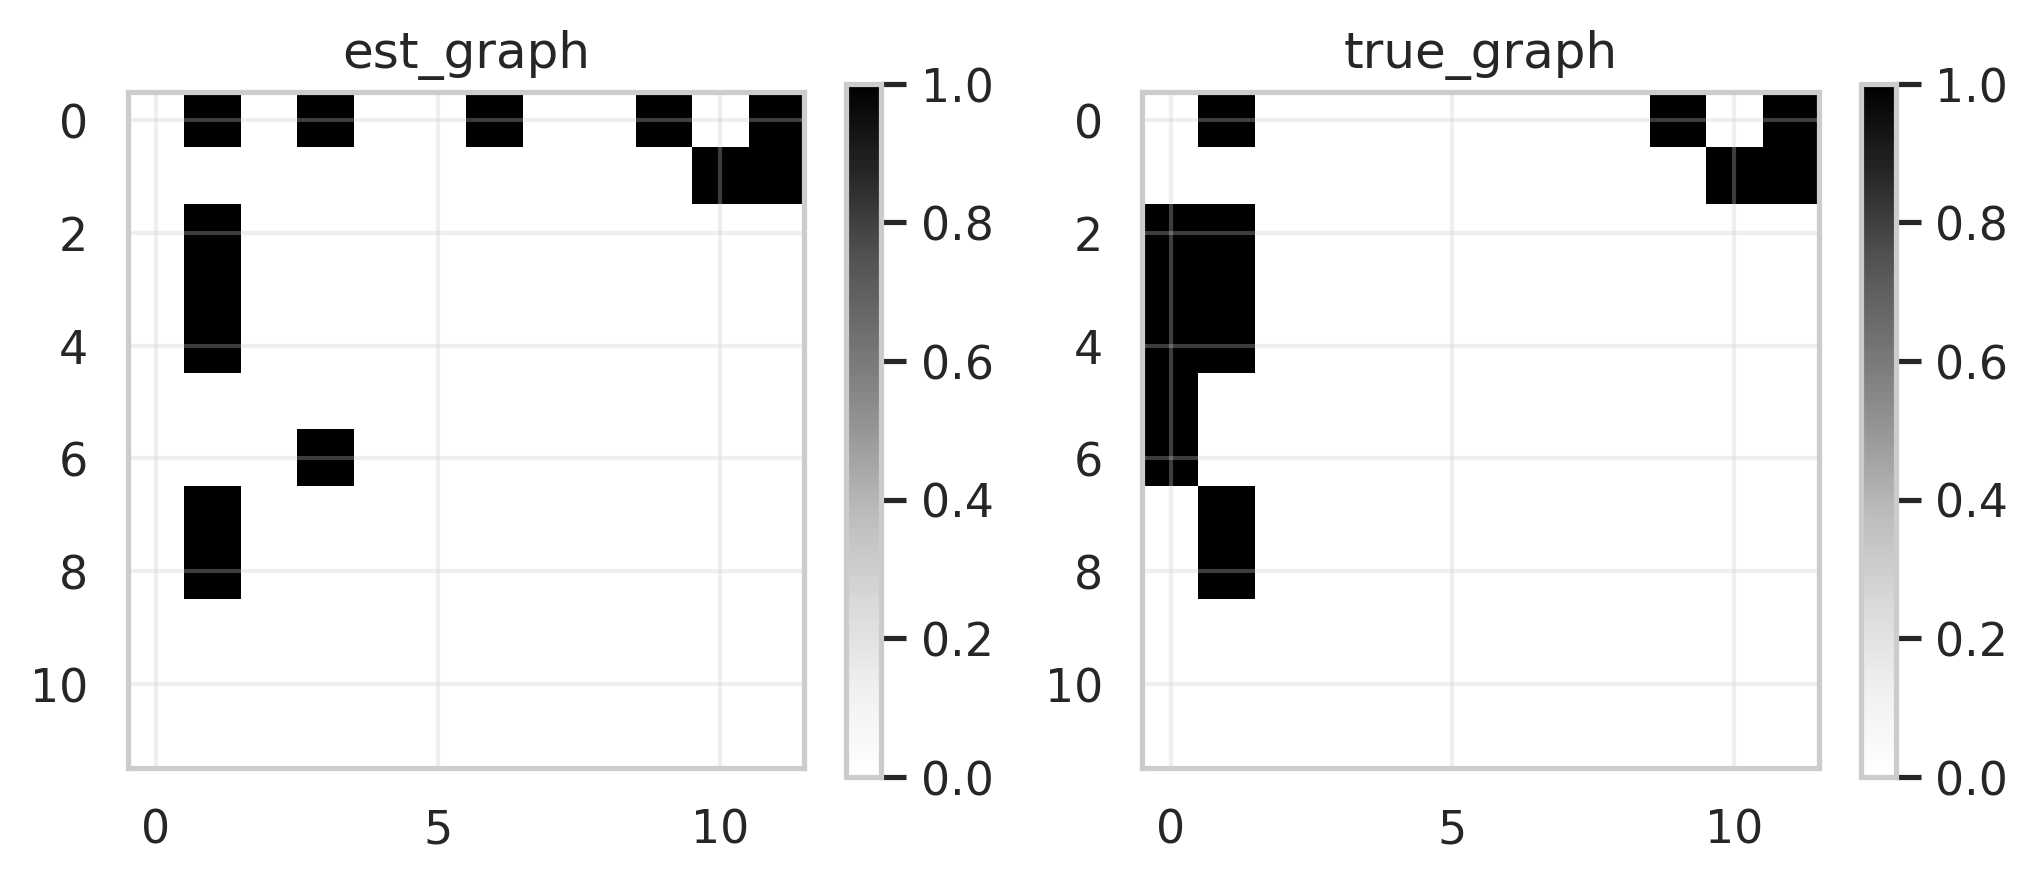

{'fdr': 0.2308, 'tpr': 0.6667, 'fpr': 0.0588, 'shd': 6, 'nnz': 13, 'precision': 0.7692, 'recall': 0.6667, 'F1': 0.7143, 'gscore': 0.4667}


In [18]:
# ICALiNGAM learn
# max_iter : int, optional (default=1000)
g_ICAlingam = ICALiNGAM(max_iter=2000, random_state=seed) # F1 of 71%
g_ICAlingam.learn(X)

# plot est_dag and true_dag
GraphDAG(g_ICAlingam.causal_matrix, B_true)

# calculate accuracy
g_ICAlingam_met = MetricsDAG(g_ICAlingam.causal_matrix, B_true)
print(g_ICAlingam_met.metrics)

W_est (without the 2nd phase) is: 
 [[ 0.      0.      0.     -0.3106  0.      0.     -0.3674  0.      0.
   0.      0.      2.1441]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.    ]
 [-1.8974 -2.6482  0.      0.      0.      0.      0.      0.      0.
   0.     -2.8644 -2.1657]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.    ]
 [ 0.     -2.3215  0.      0.      0.      0.      0.      0.      0.
   0.     -2.684  -1.8696]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.    ]
 [ 0.     -1.3041  0.      0.      0.      0.      0.      0.      0.
   0.809  -1.3049  0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.    ]
 [ 0.4132  0.4301  0.      0.      0.      0.      0.      0.      0.
   0.      0.8179  0.

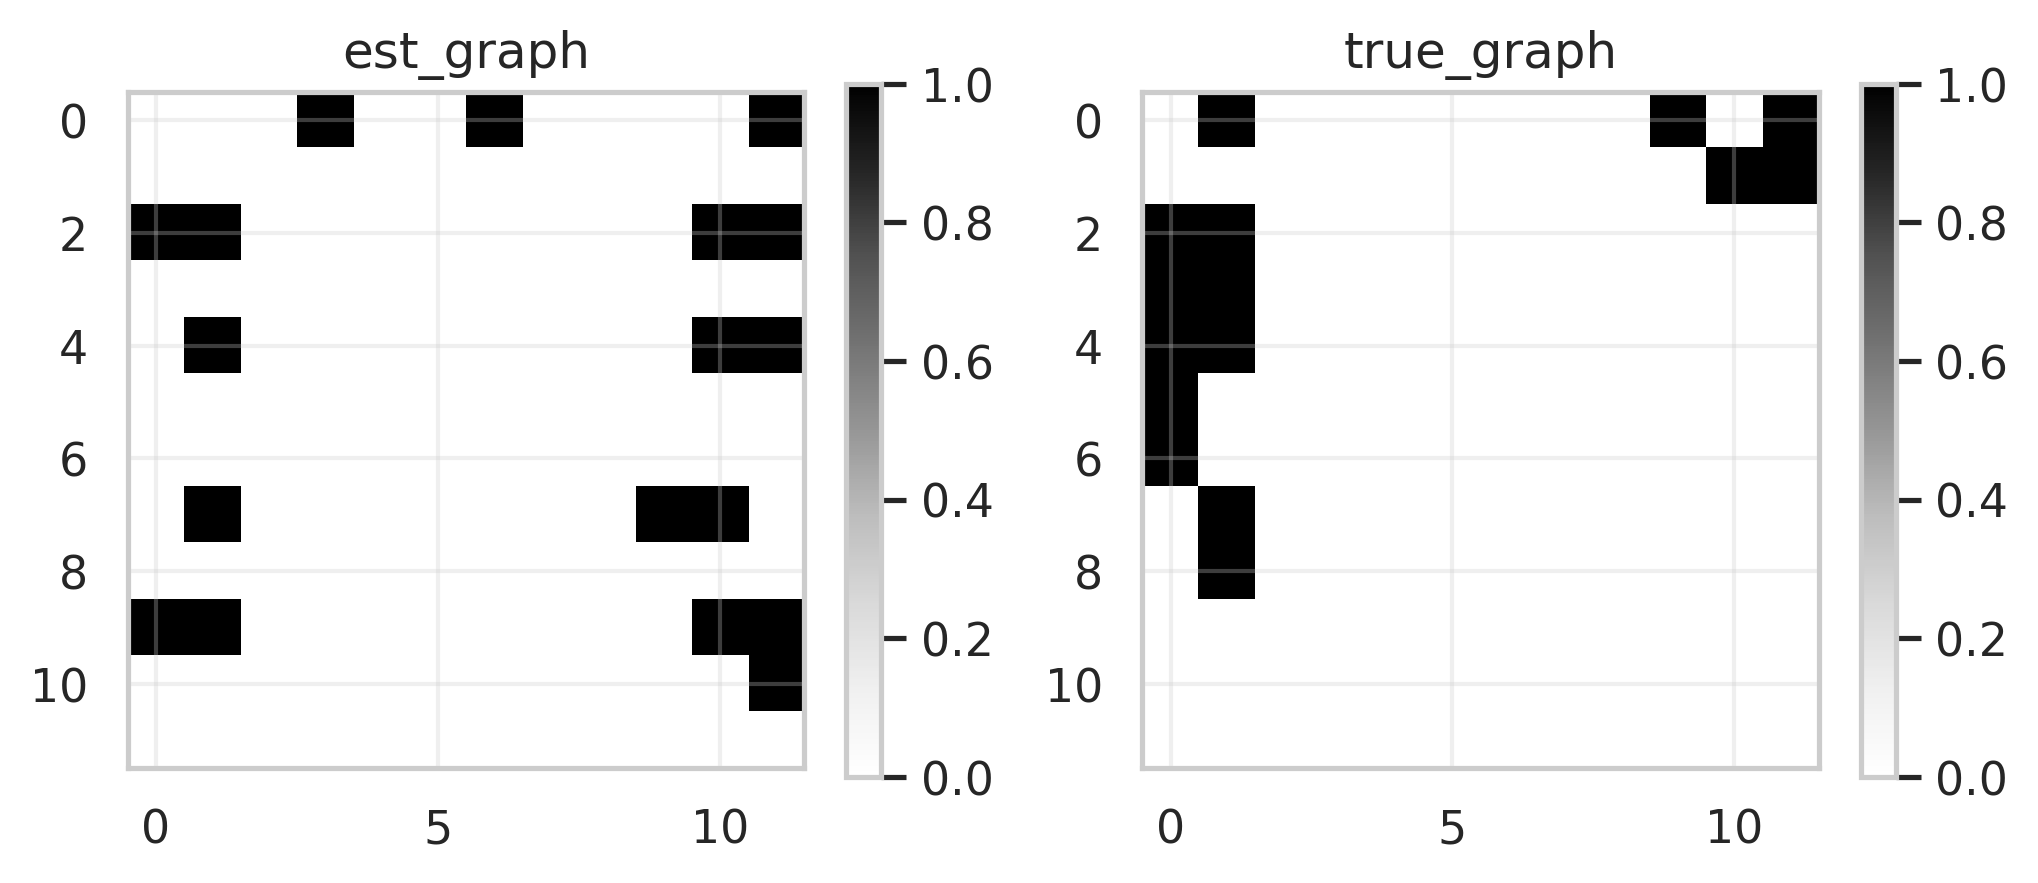

{'fdr': 0.7222, 'tpr': 0.3333, 'fpr': 0.2549, 'shd': 20, 'nnz': 18, 'precision': 0.2778, 'recall': 0.3333, 'F1': 0.303, 'gscore': 0.0}


In [19]:
# LiM from lingam library
LiM = lingam.LiM(w_threshold=0.3, max_iter=200, h_tol=1e-8, rho_max=1e12, lambda1=0.4, seed=seed) # default rho_max is 1e16
# create array of shape (1, n_features) which indicates which columns/variables in data.values are discrete or continuous variables, where "1" indicates a continuous variable, while "0" a discrete variable.
is_cont = np.array([(1 if X_df[col].nunique() > 2 else 0) for col in X_df.columns]).reshape(1, -1)
#LiM.fit(X=X, dis_con=is_cont, only_global=False) # does not finish, even fater 375 minutes
LiM.fit(X=X, dis_con=is_cont, only_global=True)

# plot est_dag and true_dag
LiM_W_est = LiM.adjacency_matrix_
LiM_B_est = compute_binary_adjacency(LiM_W_est)

GraphDAG(LiM_B_est, B_true)

# calculate accuracy
LiM_met = MetricsDAG(LiM_B_est, B_true)
print(LiM_met.metrics)

2025-02-10 08:52:15,296 - /tmp/ipykernel_958715/3541460829.py[line:141] - INFO: Starting level 0 pool with 132 remaining edges at 2025-02-10 08:52:15.296399
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
2025-02-10 08:52:17,599 - /tmp/ipykernel_958715/3541460829.py[line:141] - INFO: Starting level 1 pool with 68 remaining edges at 2025-02-10 08:52:17.598927
2025-02-10 08:52:30,978 - /tmp/ipykernel_958715/3541460829.py[line:141] - INFO: Starting level 2 pool with 14 remaining edges at 2025-02-10 08:52:30.978545
2025-02-10 08:52:35,779 - /tmp/ipykernel_958715/3541460829.py[line:141] - INFO: Starting level 3 pool with 14 remaining edges at 2025-02-10 08:52:35.779432
2025-02-10 08:52:38,715 - /tmp/ipykernel_958715/3541460829.py[line:141] - INFO: Starting level 4 pool with 14 remaining edges at 2025-02-10 08:52:38.715125
2025-02-10 08:52:40,087 - /tmp/ipykernel_958715/3541460829.py[line:141] - INFO: 

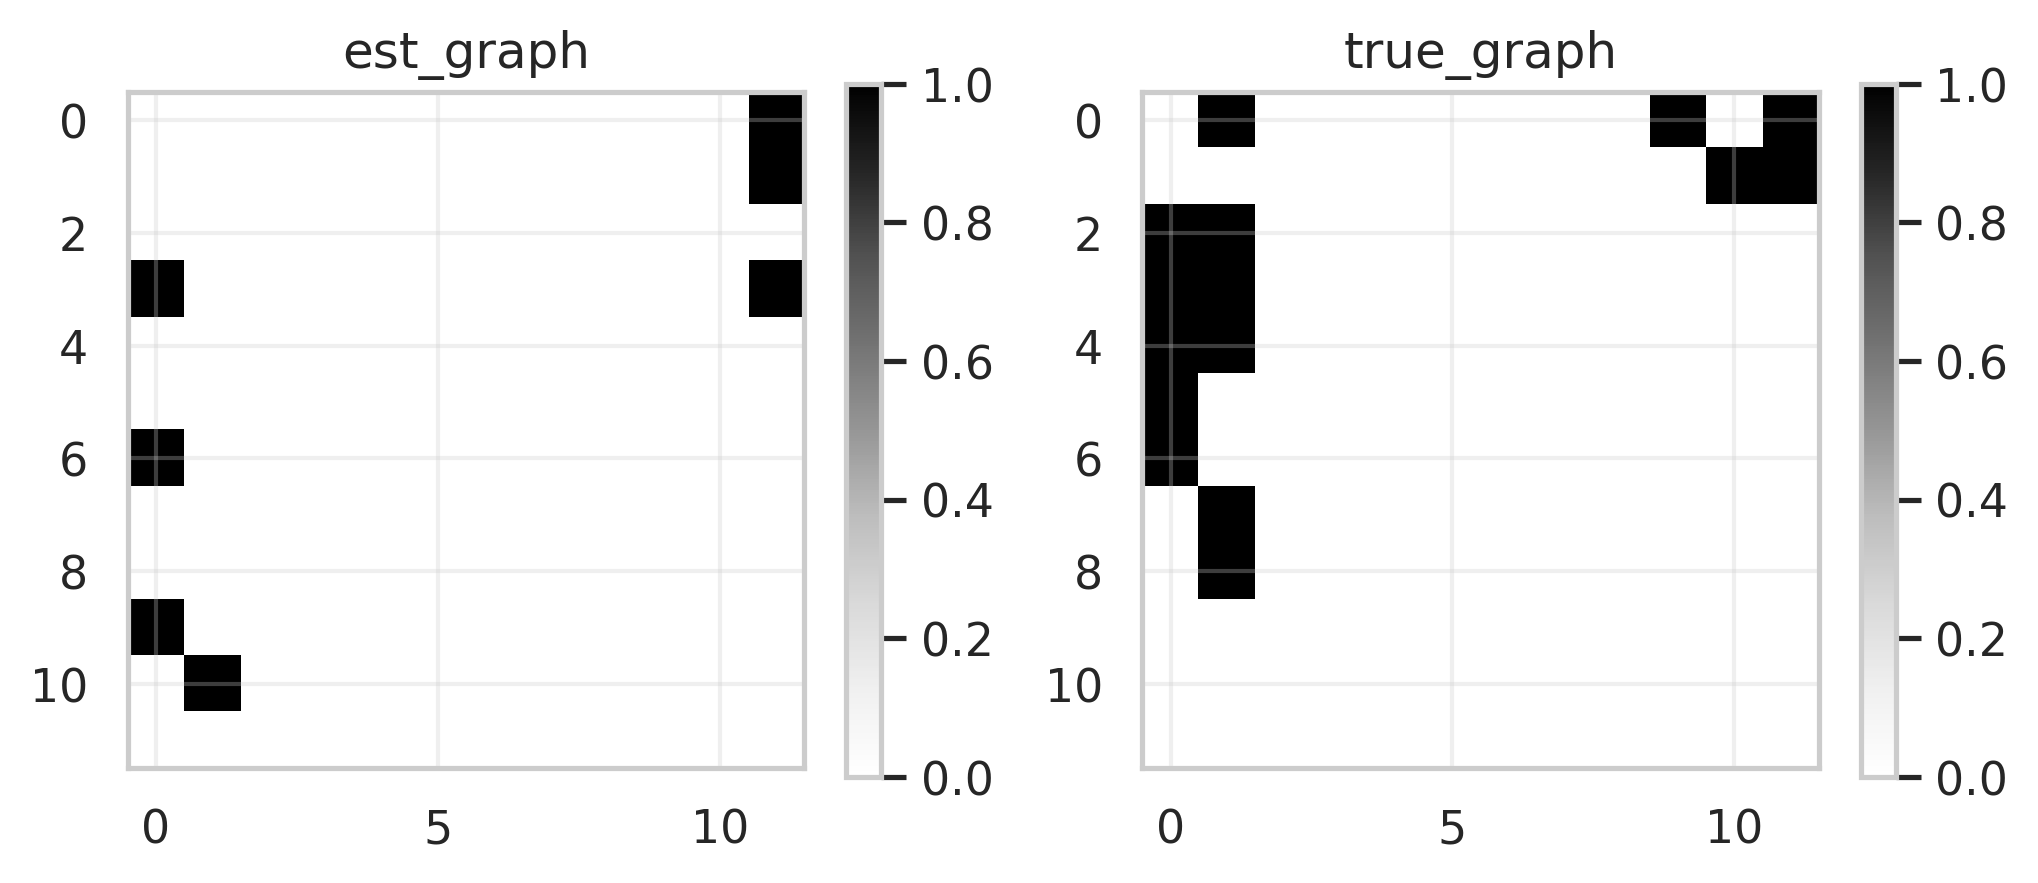

{'fdr': 0.4286, 'tpr': 0.2667, 'fpr': 0.0588, 'shd': 12, 'nnz': 7, 'precision': 0.5714, 'recall': 0.2667, 'F1': 0.3636, 'gscore': 0.0667}


In [20]:
### parallel pc alg
# A global dictionary storing the variables passed from the initializer.
var_dict = {}

def _init_worker(data, data_shape, graph, vertices, test, alpha):
    # Using a dictionary is not strictly necessary. You can also
    # use global variables.
    var_dict['data'] = data
    var_dict['data_shape'] = data_shape

    var_dict['graph'] = graph
    var_dict['vertices'] = vertices

    var_dict['alpha'] = alpha
    var_dict['test'] = test

def _test_worker(i, j, lvl):
    test = var_dict['test']
    alpha = var_dict['alpha']
    data_arr = np.frombuffer(var_dict['data']).reshape(var_dict['data_shape'])
    graph = np.frombuffer(var_dict['graph'], dtype="int32").reshape((var_dict['vertices'],
                                                                     var_dict['vertices']))
    
    # unconditional
    if lvl < 1:
        p_val = test.compute_pval(data_arr[:, [i]], data_arr[:, [j]], z=None)
        if (p_val > alpha):
            return (i, j, p_val, [])
    # conditional
    else:
        candidates_1 = np.arange(var_dict['vertices'])[(graph[i] == 1)]
        candidates_1 = np.delete(candidates_1, np.argwhere((candidates_1==i) | (candidates_1==j)))

        if (len(candidates_1) < lvl):
            return None
        
        for S in [list(c) for c in combinations(candidates_1, lvl)]:
            p_val = test.compute_pval(data_arr[:, [i]], data_arr[:, [j]], z=data_arr[:, list(S)])
            if (p_val > alpha):
                return (i, j, p_val, list(S))
            
    return None

def _unid(g, i, j):
    return g.has_edge(i, j) and not g.has_edge(j, i)

def _bid(g, i, j):
    return g.has_edge(i, j) and g.has_edge(j, i)

def _adj(g, i, j):
    return g.has_edge(i, j) or g.has_edge(j, i)

def rule1(g, j, k):
    for i in g.predecessors(j):
        # i -> j s.t. i not adjacent to k
        if _unid(g, i, j) and not _adj(g, i, k):
            g.remove_edge(k, j)
            return True
    return False

def rule2(g, i, j):
    for k in g.successors(i):
        # i -> k -> j
        if _unid(g, k, j) and _unid(g, i, k):
            g.remove_edge(j, i)
            return True
    return False

def rule3(g, i, j):
    for k, l in combinations(g.predecessors(j), 2):
        # i <-> k -> j and i <-> l -> j s.t. k not adjacent to l
        if (not _adj(g, k, l) and _bid(g, i, k) and _bid(g, i, l) and _unid(g, l, j) and _unid(g, k, j)):
            g.remove_edge(j, i)
            return True
    return False

def rule4(g, i, j):
    for l in g.predecessors(j):
        for k in g.predecessors(l):
            # i <-> k -> l -> j s.t. k not adjacent to j and i adjacent to l
            if (not _adj(g, k, j) and _adj(g, i, l) and _unid(g, k, l) and _unid(g, l, j) and _bid(g, i, k)):
                g.remove_edge(j, i)
                return True
    return False

def _direct_edges(graph, sepsets):
    digraph = nx.DiGraph(graph)
    for i in graph.nodes():
        for j in nx.non_neighbors(graph, i):
            for k in nx.common_neighbors(graph, i, j):
                sepset = sepsets[(i, j)] if (i, j) in sepsets else []
                if k not in sepset:
                    if (k, i) in digraph.edges() and (i, k) in digraph.edges():
                        digraph.remove_edge(k, i)
                    if (k, j) in digraph.edges() and (j, k) in digraph.edges():
                        digraph.remove_edge(k, j)

    bidirectional_edges = [(i, j) for i, j in digraph.edges if digraph.has_edge(j, i)]
    for i, j in bidirectional_edges:
        if _bid(digraph, i, j):
            continue
        if (rule1(digraph, i, j) or rule2(digraph, i, j) or rule3(digraph, i, j) or rule4(digraph, i, j)):
            continue

    return digraph

def parallel_stable_pc(data, estimator, alpha=0.05, processes=1, max_level=None):
    """
    Perform the Parallel Stable PC algorithm for causal discovery.

    Parameters:
    data (pd.DataFrame): The input data as a pandas DataFrame.
    estimator: The conditional independence (CI) test to be used.
    alpha (float): The significance level for the CI tests. Default is 0.05.
    processes (int): The number of processes to use for parallel computation. Default is 1.
    max_level (int or None): The maximum level of the PC algorithm. If None, no limit is set. Default is None.

    Returns:
    nx.DiGraph: The directed graph discovered by the algorithm.
    dict: The separation sets for the discovered edges.
    """
    cols = data.columns
    cols_map = np.arange(len(cols))

    data_raw = RawArray('d', data.shape[0] * data.shape[1])
    # Wrap X as an numpy array so we can easily manipulates its data.
    data_arr = np.frombuffer(data_raw).reshape(data.shape)
    # Copy data to our shared array.
    np.copyto(data_arr, data.values)

    # same magic as for data
    vertices = len(cols)
    graph_raw = RawArray('i', np.ones(vertices*vertices).astype(int))
    graph = np.frombuffer(graph_raw, dtype="int32").reshape((vertices, vertices))
    sepsets = {}

    lvls = range((len(cols) - 1) if max_level is None else min(len(cols)-1, max_level+1))
    for lvl in lvls:
        configs = [(i, j, lvl) for i, j in product(cols_map, cols_map) if i != j and graph[i][j] == 1]

        logging.info(f'Starting level {lvl} pool with {len(configs)} remaining edges at {datetime.now()}')
        with Pool(processes=processes, initializer=_init_worker,
                  initargs=(data_raw, data.shape, graph_raw, vertices, estimator, alpha)) as pool:
            result = pool.starmap(_test_worker, configs)

        for r in result:
            if r is not None:
                graph[r[0]][r[1]] = 0
                graph[r[1]][r[0]] = 0
                sepsets[(r[0], r[1])] = {'p_val': r[2], 'sepset': r[3]}

    nx_graph = nx.from_numpy_array(graph)
    nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))
    nx_digraph = _direct_edges(nx_graph, sepsets)
    nx.relabel_nodes(nx_digraph, lambda i: cols[i], copy=False)
    sepsets = {(cols[k[0]], cols[k[1]]): {'p_val': v['p_val'], 'sepset': [cols[e] for e in v['sepset']]}
               for k, v in sepsets.items()}

    return nx_digraph, sepsets

### parameters
alpha = 0.05 # significance level, increasing it will increase the number of edges
processes = 100 # set number of cores
# set mCMIkNN parameters
kcmi = 25 # number of nearest neighbors to find for mutual information estimation
kperm = 5 # neighborhood size for local permutation scheme
Mperm = 100 # linear reduction in computational cost, total number of permutations to compute for p-value estimation
#subsample = 1000 # 2 mins
subsample = 500 # 1 min
# set maximum level of pcalg (None == infinite)
max_level = None # limits the maximum size of the conditioning set

# Create an instance of the mCMIkNN class
indep_test = mCMIkNN(kcmi=kcmi, kperm=kperm, Mperm=Mperm, subsample=subsample, seed=seed)

# Run the parallel_stable_pc algorithm
graph, sepsets = parallel_stable_pc(X_df, indep_test, alpha=alpha, processes=processes, max_level=max_level)

# plot est_dag and true_dag
mCMIkNN_B_est = nx.to_numpy_array(graph)

GraphDAG(mCMIkNN_B_est, B_true)

# calculate accuracy
mCMIkNN_met = MetricsDAG(mCMIkNN_B_est, B_true)

print(mCMIkNN_met.metrics)

In [ ]:
###### PLACE METRIC COMPUTATION CODE HERE ######

# Define models and their corresponding adjacency/weight matrices
models = {
    "Our (PC)": (B_est, W_est),
    "Peter Clark": (pc.causal_matrix, None), # PC based
    "NOTEARS": (nt.causal_matrix, nt.weight_causal_matrix),
    "ICALiNGAM": (g_ICAlingam.causal_matrix, g_ICAlingam.weight_causal_matrix),
    "LiM": (LiM_B_est, LiM_W_est),
    "mCMIkNN": (mCMIkNN_B_est, None), # PC based
}

# Compute Structural Hamming Distance (SHD)
shd_absolute = {}
shd_normalized = {}
sid_absolute = {}
sid_normalized = {}
aid_absolute = {}
aid_normalized = {}
f1_scores = {}

# Compute Structural Hamming Distance (SHD)
for model_name, (B, _) in models.items():
    B_binary = (B > 0).astype(np.int8)  # Convert adjacency to binary
    shd_normalized[model_name], shd_absolute[model_name] = compute_SHD((B_true > 0).astype(np.int8), B_binary)
    sid_normalized[model_name], sid_absolute[model_name] = compute_SID((B_true > 0).astype(np.int8), B_binary)
    aid_normalized[model_name], aid_absolute[model_name] = compute_ancestor_AID((B_true > 0).astype(np.int8), B_binary)
    f1_scores[model_name] = compute_F1_directed(B_true, B)

# Compute Total Effect Estimation Error (TEE), AUROC, and AUPRC (for models with estimated weights)
tee_values = {}
auroc_values = {}
auprc_values = {}
true_total_effects = {}
est_total_effects = {}

# Indices for treatment (intervention) and target variables
interv_node_idx = 0
target_node_idx = 11

for model_name, (B, W) in models.items():
    if W is not None:  # Only compute these if W is available
        true_effect, est_effect, tee = compute_TEE(W_true, W, interv_node_idx, target_node_idx)
        _B_true = (np.abs(W_true) > 0).astype(int)
        auroc = compute_AUROC(_B_true, W)[-1]
        auprc = compute_AUPRC(_B_true, W)[-1]

        true_total_effects[model_name] = true_effect
        est_total_effects[model_name] = est_effect
        tee_values[model_name] = tee
        auroc_values[model_name] = auroc
        auprc_values[model_name] = auprc
    else:
        true_total_effects[model_name] = None
        est_total_effects[model_name] = None
        tee_values[model_name] = None
        auroc_values[model_name] = None
        auprc_values[model_name] = None

##############################################

results = [
    {
        "seed": seed,
        "method": method,
        "SHD_absolute": shd_absolute.get(method, None),
        "SHD_normalized": shd_normalized.get(method, None),
        "SID_absolute": sid_absolute.get(method, None),
        "SID_normalized": sid_normalized.get(method, None),
        "AID_absolute": aid_absolute.get(method, None),
        "AID_normalized": aid_normalized.get(method, None),
        "F1_Score": f1_scores.get(method, None),
        "TEE": tee_values.get(method, None),
        "AUROC": auroc_values.get(method, None),
        "AUPRC": auprc_values.get(method, None),
        "True_Total_Effect": true_total_effects.get(method, None),
        "Estimated_Total_Effect": est_total_effects.get(method, None),
    }
    for method in models.keys()
]

In [29]:
results

[{'seed': 2,
  'method': 'Our (PC)',
  'SHD_absolute': 1,
  'SHD_normalized': 0.015151515151515152,
  'SID_absolute': 0,
  'SID_normalized': 0.0,
  'AID_absolute': 0,
  'AID_normalized': 0.0,
  'F1_Score': 0.967741935483871,
  'TEE': 0.2467032587164948,
  'AUROC': 0.19844961240310077,
  'AUPRC': 0.4,
  'True_Total_Effect': 4.280136820473361,
  'Estimated_Total_Effect': 5.336060521836596},
 {'seed': 2,
  'method': 'Peter Clark',
  'SHD_absolute': 6,
  'SHD_normalized': 0.09090909090909091,
  'SID_absolute': 13,
  'SID_normalized': 0.09848484848484848,
  'AID_absolute': 21,
  'AID_normalized': 0.1590909090909091,
  'F1_Score': Tensor(0.75),
  'TEE': None,
  'AUROC': None,
  'AUPRC': None,
  'True_Total_Effect': None,
  'Estimated_Total_Effect': None},
 {'seed': 2,
  'method': 'NOTEARS',
  'SHD_absolute': 5,
  'SHD_normalized': 0.07575757575757576,
  'SID_absolute': 17,
  'SID_normalized': 0.12878787878787878,
  'AID_absolute': 20,
  'AID_normalized': 0.15151515151515152,
  'F1_Score': Te

In [ ]:
##################################################### EVALUATION METRICS #####################################################

In [ ]:
def evaluate_model(B_true, B_est, interv_node_idx, target_node_idx, model_name):

    # Convert adjacency matrices to binary (int8) for compatibility with `gadjid` metrics
    B_true_binary = (B_true > 0).astype(np.int8)
    B_est_binary = (B_est > 0).astype(np.int8)

    # Compute Structural Hamming Distance (SHD)
    SHD_normalized, SHD_absolute = compute_SHD(B_true_binary, B_est_binary)
    print(f"{model_name} - Structural Hamming Distance (SHD): {SHD_absolute}")
    print(f"{model_name} - Normalized SHD: {SHD_normalized}")

    # Compute Parent Adjustment Distance (SID)
    SID_normalized, SID_absolute = compute_SID(B_true_binary, B_est_binary)
    print(f"{model_name} - Structural Intervention Distance (SID): {SID_absolute}")
    print(f"{model_name} - Normalized SID: {SID_normalized}")

    # Compute Ancestor Adjustment Distance (AID)
    AID_normalized, AID_absolute = compute_ancestor_AID(B_true_binary, B_est_binary)
    print(f"{model_name} - Ancestor Adjustment Distance (AID): {AID_absolute}")
    print(f"{model_name} - Normalized AID: {AID_normalized}")

    # Compute F1 score
    F1_our = compute_F1_directed(B_true, B_est)
    print(f"{model_name} - F1 Score: {F1_our}")

def evaluate_effect(W_true, W_est, interv_node_idx, target_node_idx, model_name):
    # Compute Total Effect Estimation Error (TEE)
    true_total_effect, est_total_effect, TEE = compute_TEE(W_true, W_est, interv_node_idx, target_node_idx)
    _B_true = (np.abs(W_true) > 0).astype(int)
    auroc, auprc = compute_AUROC(_B_true, W_est)[-1], compute_AUPRC(_B_true, W_est)[-1]
    print(f"{model_name} - AUROC: {auroc}")
    print(f"{model_name} - AUPRC: {auprc}")
    print(f"{model_name} - True Total Effect: {true_total_effect}")
    print(f"{model_name} - Estimated Total Effect: {est_total_effect}")
    print(f"{model_name} - Total Effect Estimation Error (TEE): {TEE}")

# Example usage
# Indices for treatment (intervention) and target variables
interv_node_idx = 0
target_node_idx = 11
evaluate_model(B_true, B_est, interv_node_idx, target_node_idx, "Our (PC)")
print()
evaluate_effect(W_true, W_est, interv_node_idx, target_node_idx, "Our (PC)")


In [ ]:
# now do same for PC model which has its B_est stored in pc.causal_matrix
evaluate_model(B_true, pc.causal_matrix, interv_node_idx, target_node_idx, "Peter Clark")

In [ ]:
# NOTEARS with nt.causal_matrix
evaluate_model(B_true, nt.causal_matrix, interv_node_idx, target_node_idx, "NOTEARS")
print()
evaluate_effect(W_true, nt.weight_causal_matrix, interv_node_idx, target_node_idx, "NOTEARS")

In [ ]:
# ICALiNGAM with g_ICAlingam.causal_matrix
evaluate_model(B_true, g_ICAlingam.causal_matrix, interv_node_idx, target_node_idx, "ICALiNGAM")
print()
evaluate_effect(W_true, g_ICAlingam.weight_causal_matrix, interv_node_idx, target_node_idx, "ICALiNGAM")

In [ ]:
# LiM with LiM_B_est
evaluate_model(B_true, LiM_B_est, interv_node_idx, target_node_idx, "LiM")

In [ ]:
# mCMIkNN with graph, note that graph is a networkx graph so we need to convert it to adjacency matrix
evaluate_model(B_true, mCMIkNN_B_est, interv_node_idx, target_node_idx, "mCMIkNN")

In [ ]:
################################ MISC MODELS AND CODE ################################

In [ ]:
# GES learn
# method is one of ['r2', 'scatter']
ges = GES() # F1 of 47%
#ges = GES(criterion='bic', method='scatter') # F1 of 47%
#ges = GES(criterion='bic', method='r2') # F1 of 4%

# learn the graph structure
ges.learn(X)

# plot est_dag and true_dag
GraphDAG(ges.causal_matrix, B_true)

# calculate accuracy
ges_met = MetricsDAG(ges.causal_matrix, B_true)
print(ges_met.metrics)

# DirectLiNGAM learn
# measure : {'pwling', 'kernel'}, default='pwling'
g_dlingam = DirectLiNGAM(measure='pwling') # F1 of 74%
#g = DirectLiNGAM(measure='kernel') # F1 of nan - takes too long to run (even after 15 minutes not done)
g_dlingam.learn(X)

# plot est_dag and true_dag
GraphDAG(g_dlingam.causal_matrix, B_true)

# calculate accuracy
g_dlingam_met = MetricsDAG(g_dlingam.causal_matrix, B_true)
print(g_dlingam_met.metrics)